# Advanced Machine Learning Final Project - Travel Habits
## **Unsupervised Learning**
* Eylon Yehiel
* Michael Mutter

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder ,StandardScaler

import warnings

C:\Users\elon2\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
warnings.filterwarnings('ignore')

In [4]:
p1 = os.getcwd()+'\\TH-data\\aas_1.csv'
p2 = os.getcwd()+'\\TH-data\\vvs_1.csv'
p3 = os.getcwd()+'\\TH-data\\hhs_1.csv'
p4 = os.getcwd()+'\\TH-data\\pps_1.csv'
# Activities, Vechiles, households and people.
aas, vvs, hhs, pps = (pd.read_csv(file) for file in [p1, p2, p3, p4])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
print('Activities:\n', aas.columns, '\n===============================================================================')
print('Vechiles:\n', vvs.columns, '\n===============================================================================')
print('HouseHolds:\n', hhs.columns, '\n===============================================================================')
print('Individuals:\n', pps.columns, '\n===============================================================================')

Activities:
 Index(['survey3', 'HHID3', 'IndID3', 'SurveyDay', 'placeno', 'mainActivity',
       'mainmode', 'numAccomp', 'arrtime', 'deptime', 'parkType', 'wf3',
       'TypNdx', 'STStr', 'STArr', 'STDep', 'TrvlTime', 'TrvlDist', 'StayTime',
       'actGizra', 'actSemel', 'actTaz', 'locType', 'PerID3', 'tfrs', 'legs',
       'Times', 'Dists', 'version'],
      dtype='object') 
Vechiles:
 Index(['survey11', 'hhid11', 'vehid', 'Ownership', 'FuelCost', 'HomeParking',
       'wf11', 'version'],
      dtype='object') 
HouseHolds:
 Index(['survey1', 'survey_num', 'hhid', 'sector', 'hhsize', 'HHChild8',
       'hhveh', 'hhmicroveh', 'days', 'day1', 'day2', 'wf1', 'hhSemel',
       'Yshuvtype', 'Mahoz', 'Gizra', 'hhtaz', 'Mosad', 'HHType', 'HHMembers',
       'year', 'version'],
      dtype='object') 
Individuals:
 Index(['survey2', 'hhid2', 'indID', 'relat', 'gender', 'age', 'degree',
       'study', 'EmpStat', 'workparking', 'clic', 'mlic', 'device', 'days2',
       'acts1', 'acts2', 'wf2',

In [6]:
# Connection of the data
unique_pps = aas.PerID3.unique()
unique_hhs = aas.HHID3.unique()
print(len(unique_pps))
print(len(unique_hhs))

129230
38547


In [7]:
# Making sure that residuals wont' not remain and turn into NaN.
set(aas['PerID3']) == set(pps['PerID']) and set(hhs['hhid']) == set(aas['HHID3'])

True

---

## Data preparation:

##### Keep only enrties of travels - remove first activities and data of staying at home (travel distance = 0)

In [11]:
travels = aas[aas.TrvlDist.notnull()]
travels.shape

(655388, 29)

In [12]:
travels.rename(columns = {'HHID3':'hhid','PerID3':'PerID'}, inplace = True)
# Merge data sets for features to make informative models
df = travels.merge(hhs, how = 'left', on = 'hhid').merge(pps, how = 'left', on = 'PerID')


In [13]:
df.columns

Index(['survey3', 'hhid', 'IndID3', 'SurveyDay', 'placeno', 'mainActivity',
       'mainmode', 'numAccomp', 'arrtime', 'deptime', 'parkType', 'wf3',
       'TypNdx', 'STStr', 'STArr', 'STDep', 'TrvlTime', 'TrvlDist', 'StayTime',
       'actGizra', 'actSemel', 'actTaz', 'locType', 'PerID', 'tfrs', 'legs',
       'Times', 'Dists', 'version_x', 'survey1', 'survey_num', 'sector',
       'hhsize', 'HHChild8', 'hhveh', 'hhmicroveh', 'days', 'day1', 'day2',
       'wf1', 'hhSemel', 'Yshuvtype', 'Mahoz', 'Gizra', 'hhtaz', 'Mosad',
       'HHType', 'HHMembers', 'year', 'version_y', 'survey2', 'hhid2', 'indID',
       'relat', 'gender', 'age', 'degree', 'study', 'EmpStat', 'workparking',
       'clic', 'mlic', 'device', 'days2', 'acts1', 'acts2', 'wf2', 'version'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655388 entries, 0 to 655387
Data columns (total 68 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   survey3       655388 non-null  object 
 1   hhid          655388 non-null  int64  
 2   IndID3        655388 non-null  int64  
 3   SurveyDay     655388 non-null  int64  
 4   placeno       655388 non-null  int64  
 5   mainActivity  655388 non-null  int64  
 6   mainmode      655388 non-null  int64  
 7   numAccomp     593571 non-null  float64
 8   arrtime       655388 non-null  object 
 9   deptime       655388 non-null  object 
 10  parkType      242326 non-null  float64
 11  wf3           655388 non-null  float64
 12  TypNdx        655388 non-null  int64  
 13  STStr         655388 non-null  float64
 14  STArr         655388 non-null  float64
 15  STDep         655388 non-null  float64
 16  TrvlTime      655388 non-null  float64
 17  TrvlDist      655388 non-null  float64
 18  Stay

In [15]:
# Calculation of the percentage of empty values ​​for all columns
missing_percentages = (df.isnull().mean() * 100).sort_values(ascending=False)

print("pecentage in every column")
print(missing_percentages)


pecentage in every column
tfrs        91.502438
legs        91.502438
Times       91.502438
Dists       91.502438
parkType    63.025567
              ...    
hhsize       0.000000
HHChild8     0.000000
hhid         0.000000
days         0.000000
version      0.000000
Length: 68, dtype: float64


In [16]:
# Removing columns with more than 40% missing values
columns_to_drop = missing_percentages[missing_percentages > 40].index
df = df.drop(columns=columns_to_drop)

print(df.head()) 

  survey3     hhid  IndID3  SurveyDay  placeno  mainActivity  mainmode  \
0     bsh  1000060       1          1        2             5         1   
1     bsh  1000060       1          1        3             5         1   
2     bsh  1000060       1          1        4             1         1   
3     bsh  1000060       1          1        5             3        10   
4     bsh  1000060       1          1        6             5        10   

   numAccomp              arrtime              deptime  ...  degree  study  \
0        1.0  19/02/2014 11:57:35  19/02/2014 12:23:59  ...     5.0    2.0   
1        1.0  19/02/2014 12:33:59  19/02/2014 13:36:00  ...     5.0    2.0   
2        1.0  19/02/2014 13:45:02  19/02/2014 16:50:00  ...     5.0    2.0   
3        1.0  19/02/2014 16:57:00  19/02/2014 18:00:00  ...     5.0    2.0   
4        1.0  19/02/2014 18:08:59  19/02/2014 19:50:00  ...     5.0    2.0   

   EmpStat  clic  mlic  device  days2  acts1        wf2  version  
0      1.0   1.0   

### Feature selection

In [18]:
# removing dates and times
df = df.drop(columns=['days','days2','day1','day2','arrtime','deptime','TrvlTime','deptime','STStr','STArr','STDep','indID']) 
# Removal of identifiers that do not contribute to data and are not behavioral attributes
df = df.drop(columns=['year','Yshuvtype','hhSemel','Mahoz','Gizra','PerID','hhid','SurveyDay','survey1','survey2','survey3','IndID3','wf2','wf1','wf3','survey_num','version_x','version','version_y','placeno','hhid2'])
# Removing a string of family members' names - not relevant
df = df.drop(columns=['HHMembers'])
# Removing a survey tool with which the surveys were measured
df = df.drop(columns=['device'])


In [19]:
num_rows_with_99 = df.isin([99]).any(axis=1).sum()
print(f"Number of rows containing the value 99: {num_rows_with_99}")
df = df[~df.isin([99]).any(axis=1)]


Number of rows containing the value 99: 3523


In [20]:
# Replace missing values in these columns to 9 (9 -> unknown due to metadata)
df[['degree', 'study', 'EmpStat', 'clic', 'mlic']] = df[['degree', 'study', 'EmpStat', 'clic', 'mlic']].fillna(value=9)

# Assuming number of acts in first day is the median value of all activities amount
df[['acts1']] = df[['acts1']].fillna(value=df['acts1'].median())

# Same assumption about age
df[['age']] = df[['age']].fillna(value=df['age'].median())

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651865 entries, 0 to 655387
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   mainActivity  651865 non-null  int64  
 1   mainmode      651865 non-null  int64  
 2   numAccomp     590194 non-null  float64
 3   TypNdx        651865 non-null  int64  
 4   TrvlDist      651865 non-null  float64
 5   StayTime      651865 non-null  float64
 6   actGizra      651756 non-null  float64
 7   actSemel      651738 non-null  float64
 8   actTaz        651751 non-null  float64
 9   locType       651865 non-null  int64  
 10  sector        651865 non-null  int64  
 11  hhsize        651865 non-null  int64  
 12  HHChild8      651865 non-null  int64  
 13  hhveh         651865 non-null  int64  
 14  hhtaz         651865 non-null  int64  
 15  HHType        651865 non-null  int64  
 16  relat         651865 non-null  int64  
 17  gender        651865 non-null  int64  
 18  age      

In [22]:
df.shape

(651865, 25)

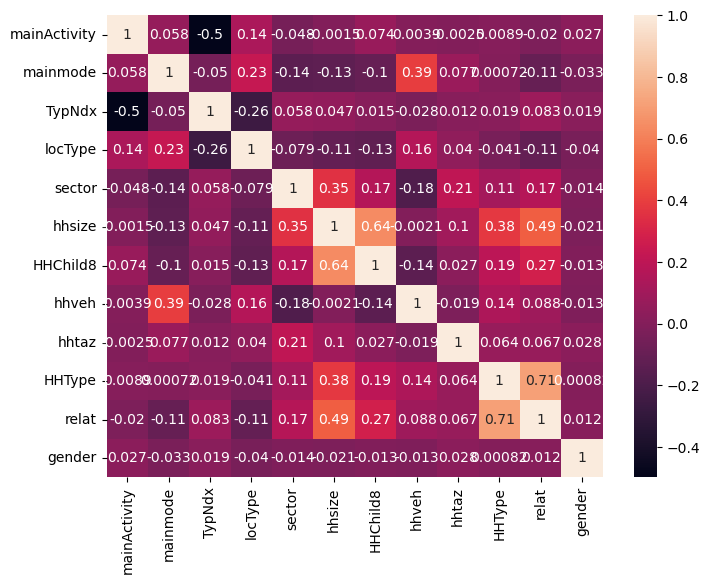

<Figure size 1200x1000 with 0 Axes>

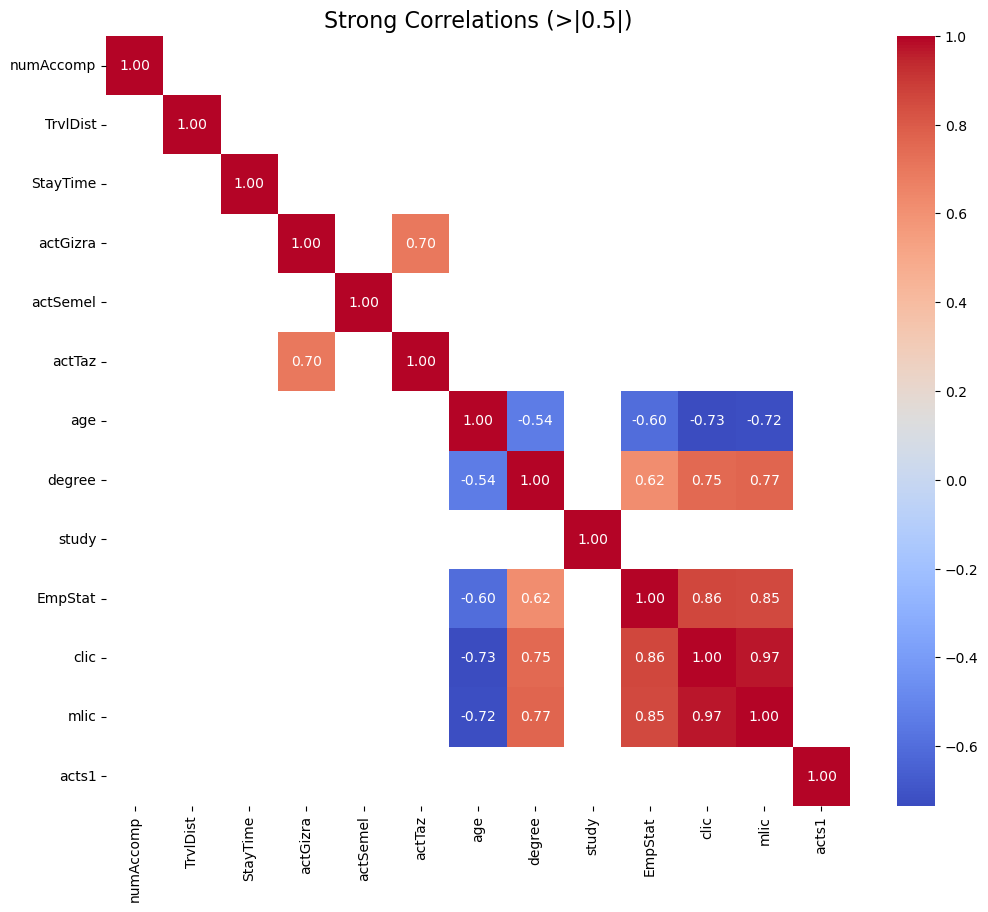

In [23]:
numeric_cols = df.select_dtypes(include=['int64']).columns
df_numeric = df[numeric_cols]
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot = True)

numeric_cols = df.select_dtypes(include=['float64']).columns
df_numeric = df[numeric_cols]
plt.figure(figsize=(12, 10))
correlation = df_numeric.corr()

strong_corr = correlation[(correlation > 0.5) | (correlation < -0.5)]

plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Strong Correlations (>|0.5|)", fontsize=16)
plt.show()

In [24]:
# We will drop columns according to the high correlations
df = df.drop(columns=['actGizra','actSemel','actTaz','HHChild8','hhtaz','clic','EmpStat','TypNdx'])

        PC1       PC2
0 -0.201674  0.010827
1 -0.167607 -0.048085
2  0.033951 -0.702448
3 -0.387164  0.420092
4 -0.390093  0.578646


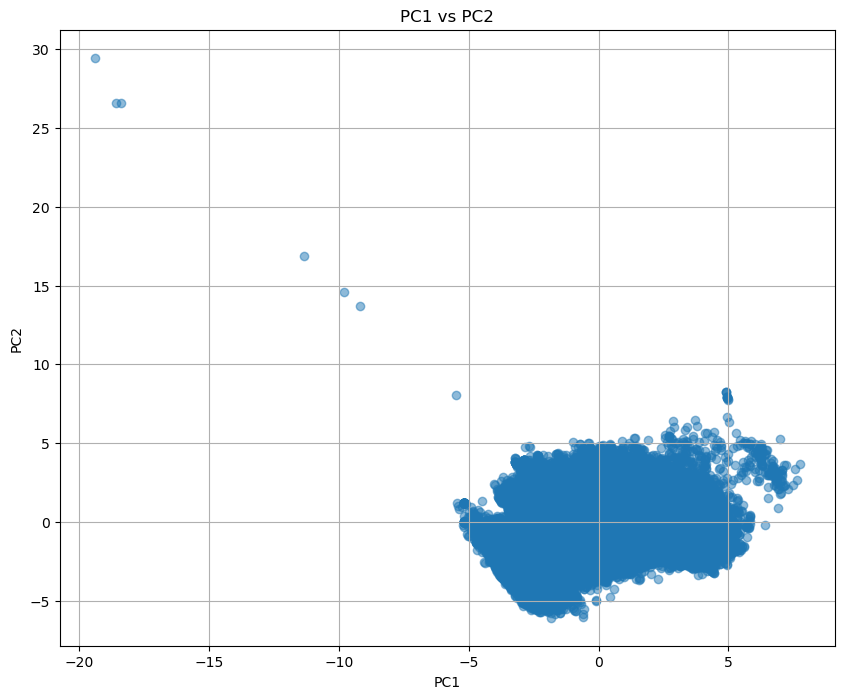

In [25]:
# Drop rows with missing values
pca_df = df.dropna()
numeric_cols = pca_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(pca_df[numeric_cols])
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print(pca_df.head())
plt.figure(figsize=(10, 8))  

# Plot PC1 vs PC2
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.grid(True)

plt.show()


In [26]:
# Descriptive statistics
print("Overview of the data: \n", df.info())
print("\ Descriptive statistics:\n", df.describe())

missing_percentage = df.isnull().mean() * 100
print("\nPercentage of missing values ​​for each column:\n", missing_percentage[missing_percentage > 0])

<class 'pandas.core.frame.DataFrame'>
Index: 651865 entries, 0 to 655387
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   mainActivity  651865 non-null  int64  
 1   mainmode      651865 non-null  int64  
 2   numAccomp     590194 non-null  float64
 3   TrvlDist      651865 non-null  float64
 4   StayTime      651865 non-null  float64
 5   locType       651865 non-null  int64  
 6   sector        651865 non-null  int64  
 7   hhsize        651865 non-null  int64  
 8   hhveh         651865 non-null  int64  
 9   HHType        651865 non-null  int64  
 10  relat         651865 non-null  int64  
 11  gender        651865 non-null  int64  
 12  age           651865 non-null  float64
 13  degree        651865 non-null  float64
 14  study         651865 non-null  float64
 15  mlic          651865 non-null  float64
 16  acts1         651865 non-null  float64
dtypes: float64(8), int64(9)
memory usage: 89.5 MB
Overvie

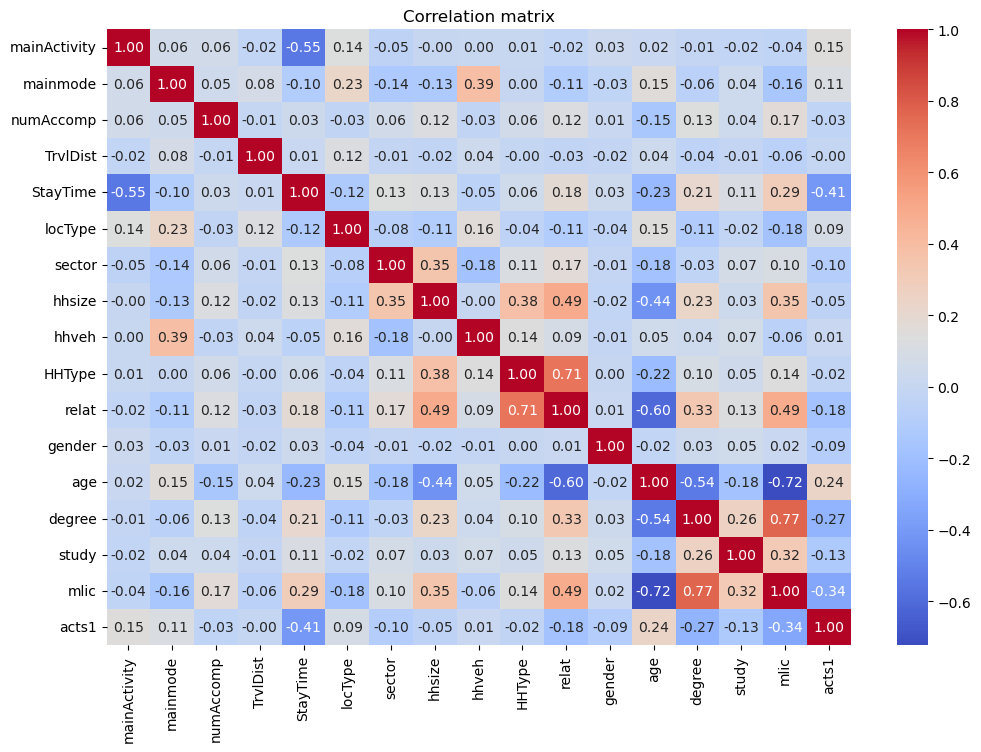

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

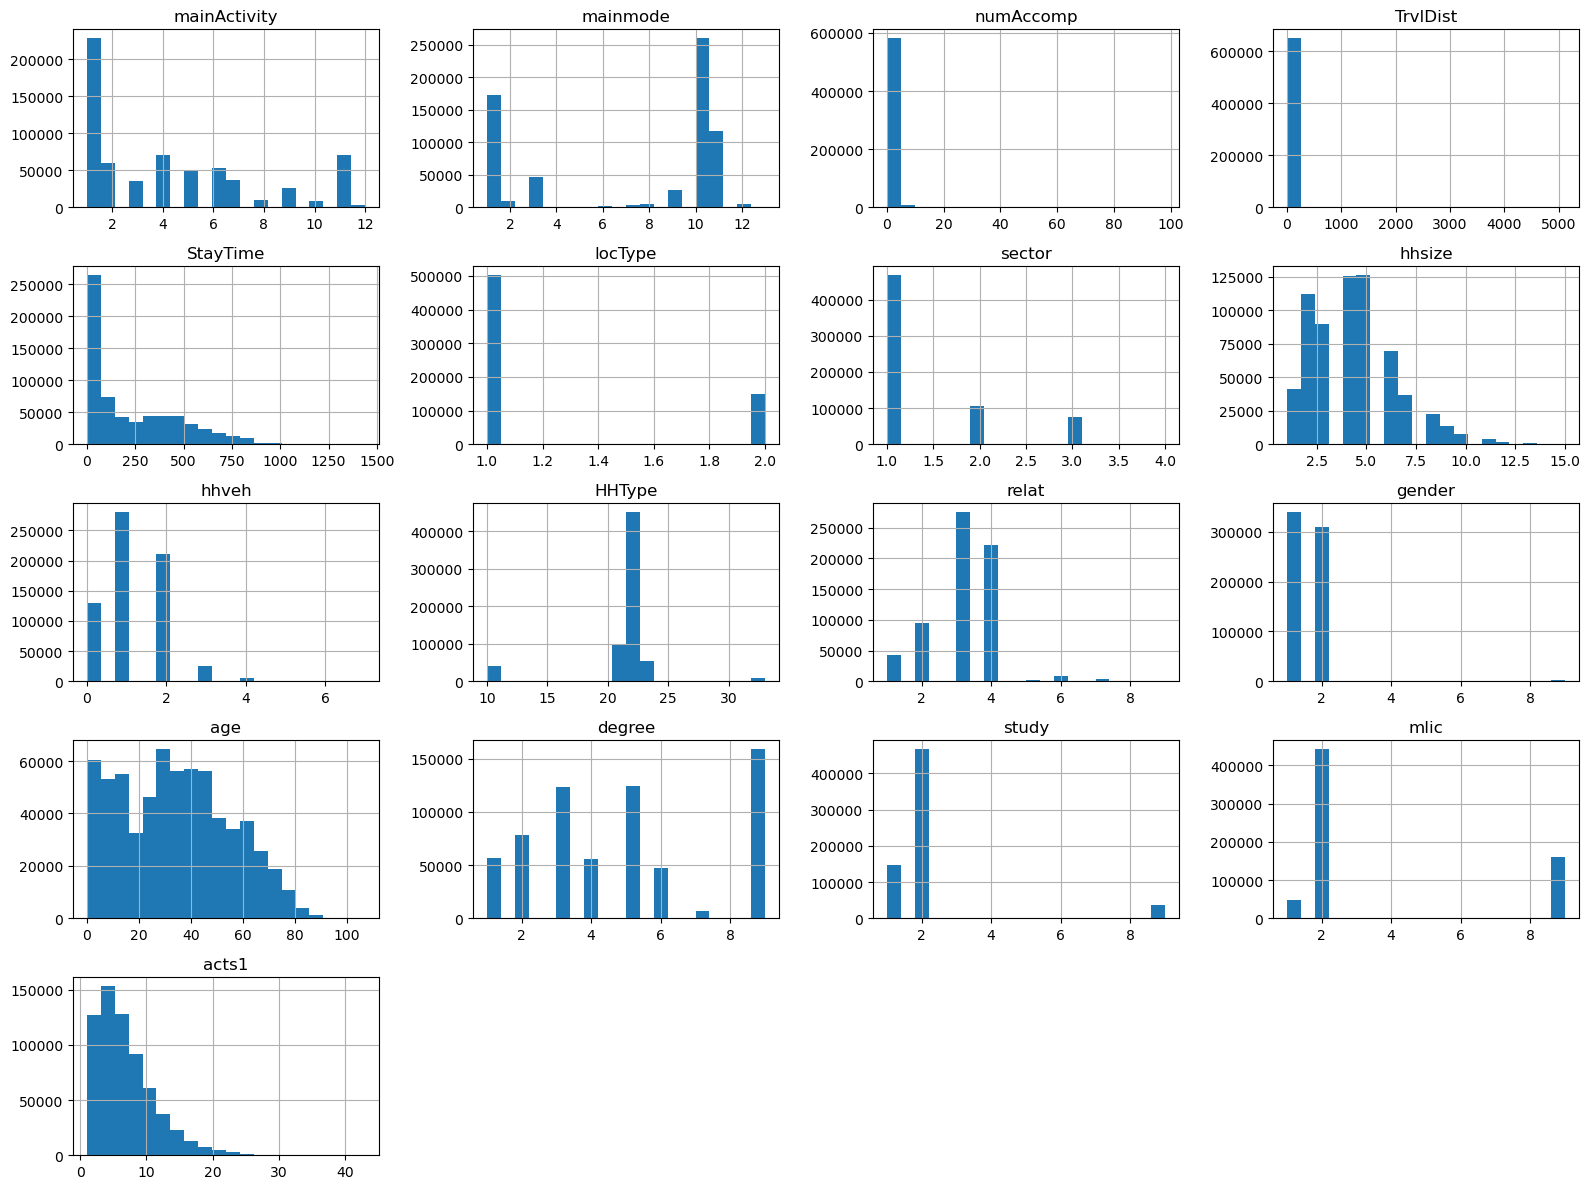

In [28]:
df.hist(figsize=(16, 12), bins=20)
plt.tight_layout()
plt.show()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651865 entries, 0 to 655387
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   mainActivity  651865 non-null  int64  
 1   mainmode      651865 non-null  int64  
 2   numAccomp     590194 non-null  float64
 3   TrvlDist      651865 non-null  float64
 4   StayTime      651865 non-null  float64
 5   locType       651865 non-null  int64  
 6   sector        651865 non-null  int64  
 7   hhsize        651865 non-null  int64  
 8   hhveh         651865 non-null  int64  
 9   HHType        651865 non-null  int64  
 10  relat         651865 non-null  int64  
 11  gender        651865 non-null  int64  
 12  age           651865 non-null  float64
 13  degree        651865 non-null  float64
 14  study         651865 non-null  float64
 15  mlic          651865 non-null  float64
 16  acts1         651865 non-null  float64
dtypes: float64(8), int64(9)
memory usage: 89.5 MB


In [30]:
# handaling missing values
mean_value_numAccomp = df['numAccomp'].mean()
df['numAccomp'] = df['numAccomp'].fillna(mean_value_numAccomp)


mean_hhsize = df['hhsize'].mean()
df['hhsize'] = df['hhsize'].fillna(mean_hhsize)


mean_hhveh = df['hhveh'].mean()
df['hhveh'] = df['hhveh'].fillna(mean_hhveh)


df['sector'] = df['sector'].fillna(9)
df['HHType'] = df['HHType'].fillna(10)

In [31]:
numeric_features = ['numAccomp','TrvlDist','StayTime','hhsize','hhveh','age','acts1']
categorical_features = ['mainActivity', 'mainmode','locType','sector','HHType','relat','gender','degree','study','mlic']  # לדוגמה


##### Ready to go

## DBSCAN

In [34]:
important_featuresDB = ['mainActivity','mainmode','age','TrvlDist','gender','StayTime','locType','relat','sector','hhsize','degree','study']


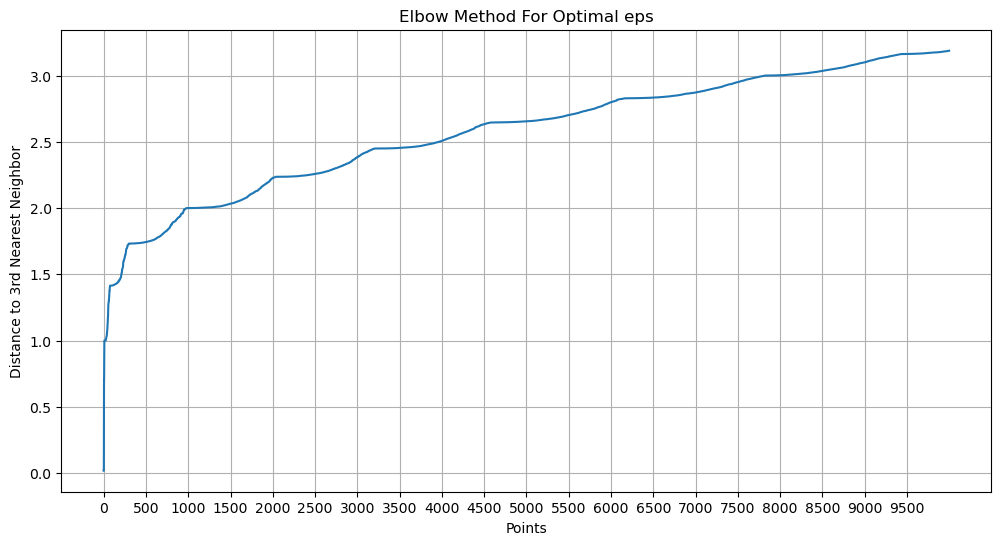

In [35]:
# ### CODE BY GPT### 
df_sampledDB = df.sample(frac=0.1, random_state=42)

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(df_sampledDB)
distances, indices = neighbors_fit.kneighbors(df_sampledDB)

# Sort the distances to the third nearest neighbor
sorted_distances = np.sort(distances, axis=0)[:, 2]

# Focus on a more specific range to pinpoint the elbow
# This will depend on observing the data and choosing limits that best display the elbow
start_index = 0  # adjust this based on your specific dataset
end_index = 10000  # adjust this based on your specific dataset

plt.figure(figsize=(12, 6))
plt.plot(sorted_distances[start_index:end_index])
plt.title('Elbow Method For Optimal eps')
plt.xlabel('Points')
plt.ylabel('Distance to 3rd Nearest Neighbor')
plt.xticks(np.arange(start_index, end_index, step=500))  # adjust the step based on your data range
plt.grid(True)
plt.show()

   mainActivity  mainmode  numAccomp   TrvlDist   StayTime  locType  sector  \
0           5.0      10.0   0.000000  19.868800    6.41667      1.0     1.0   
1           1.0       1.0   0.000000   1.192320  354.98300      1.0     3.0   
2           4.0       2.0   2.000000   0.463754  360.00000      1.0     2.0   
3           4.0       1.0   0.908715   0.148587  288.00000      1.0     1.0   
4           1.0      11.0   1.000000  14.483500  362.00000      1.0     1.0   

   hhsize  hhveh  HHType  relat  gender   age  degree  study  mlic  acts1  \
0     5.0    2.0    22.0    3.0     2.0  40.0     5.0    2.0   2.0   10.0   
1     2.0    1.0    21.0    2.0     1.0  25.0     3.0    2.0   2.0    3.0   
2     5.0    1.0    22.0    4.0     2.0   7.0     9.0    2.0   9.0    3.0   
3     4.0    2.0    22.0    4.0     2.0  12.0     9.0    1.0   9.0    7.0   
4     6.0    2.0    23.0    4.0     1.0  19.0     4.0    1.0   2.0    3.0   

   Cluster  
0        0  
1        0  
2        0  
3        0

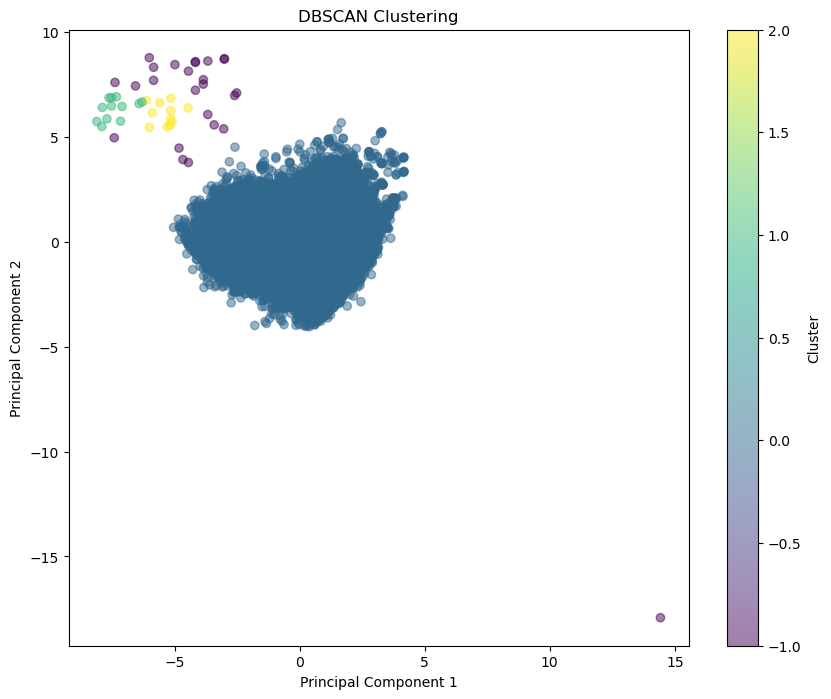

In [36]:
# We will take 10 percent of the data because runtime considerations
df_sampledDB = df.sample(frac=0.1, random_state=42)
imputerDB = SimpleImputer(strategy='constant', fill_value=9)
df_imputedDB = pd.DataFrame(imputerDB.fit_transform(df_sampledDB), columns=df_sampledDB.columns)

numeric_featuresDB = ['numAccomp','TrvlDist','StayTime','hhsize','hhveh','age','acts1']
categorical_featuresDB = ['mainActivity', 'mainmode','locType','sector','HHType','relat','gender','degree','study','mlic']

preprocessorDB = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_featuresDB),
        ('cat', OneHotEncoder(), categorical_featuresDB)
    ])

df_preparedDB = preprocessorDB.fit_transform(df_imputedDB)
df_denseDB = df_preparedDB.toarray()  
pcaDB = PCA(n_components=2) 
df_pcaDB = pcaDB.fit_transform(df_denseDB)

# DBSCAN
dbscanDB = DBSCAN(eps=1, min_samples=10)
clustersDB = dbscanDB.fit_predict(df_pcaDB)
df_imputedDB['Cluster'] = clustersDB
print(df_imputedDB.head())


#DBSCAN to PCA
df_pcaDB = pd.DataFrame(df_pcaDB, columns=['PC1', 'PC2'])
df_pcaDB['Cluster'] = clustersDB

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pcaDB['PC1'], df_pcaDB['PC2'], c=df_pcaDB['Cluster'], cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


### Cluster analysis

In [38]:
#Silhouette Score
score = silhouette_score(df_denseDB, clustersDB)
print("Silhouette Score: ", score)


Silhouette Score:  0.8661240432146285


In [39]:
pivot_table = df_imputedDB.groupby('Cluster')[numeric_featuresDB].mean()
print(pivot_table)


         numAccomp    TrvlDist    StayTime    hhsize     hhveh        age  \
Cluster                                                                     
-1       90.396349  209.358704  193.644012  5.000000  1.320000  40.640000   
 0        0.858874    5.013194  231.426397  4.329009  1.239476  34.038426   
 1       98.000000    5.633411  472.852750  5.750000  1.250000   9.666667   
 2       96.363636    7.971008  391.157576  4.181818  1.000000  31.090909   

             acts1  
Cluster             
-1       10.640000  
 0        7.197074  
 1        3.666667  
 2        5.636364  


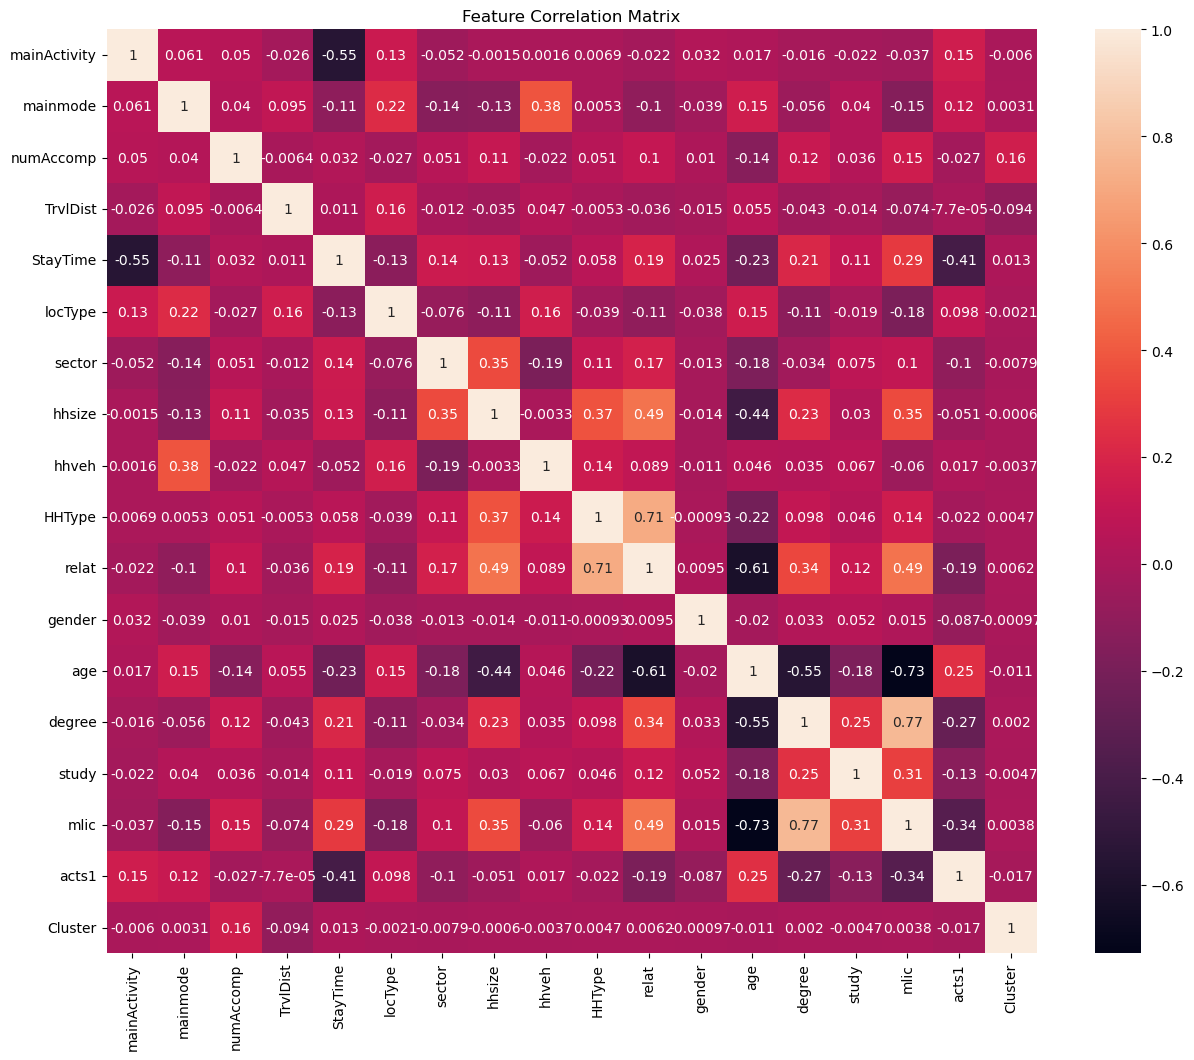

In [40]:
# Correlations between the features
correlation_matrix = df_imputedDB.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Feature Correlation Matrix")
plt.show()


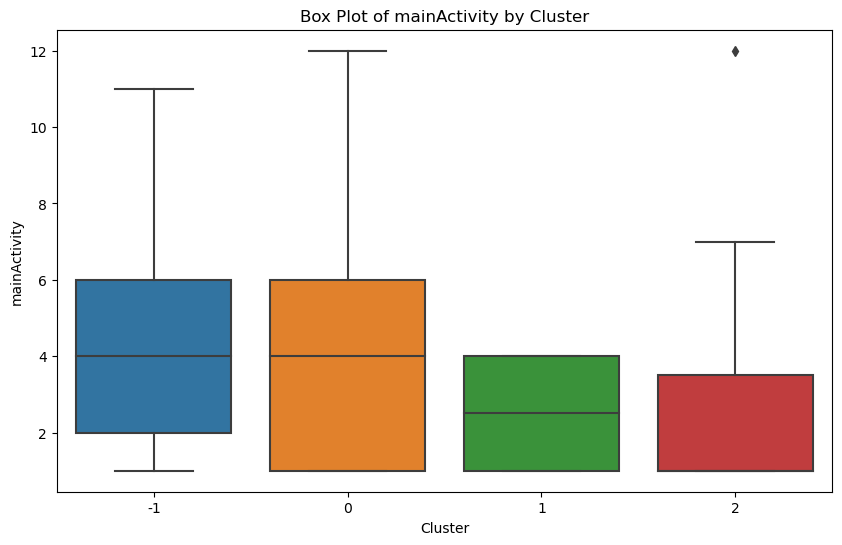

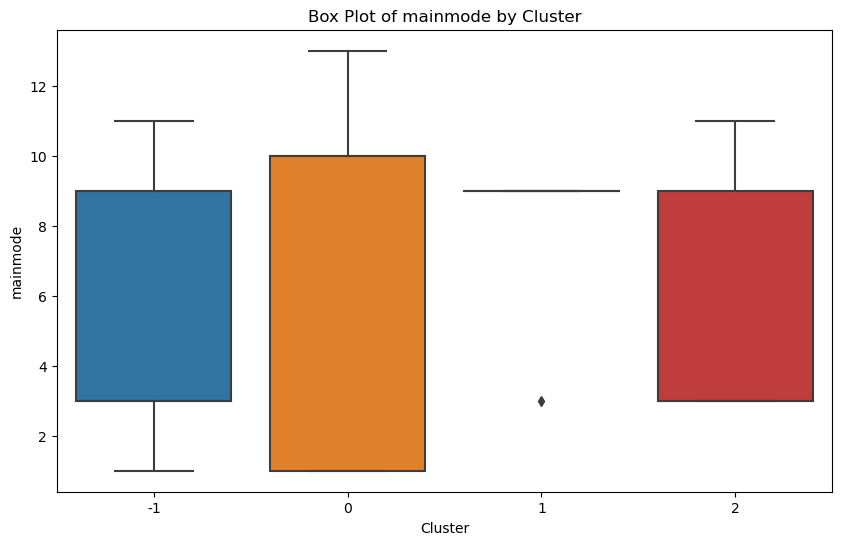

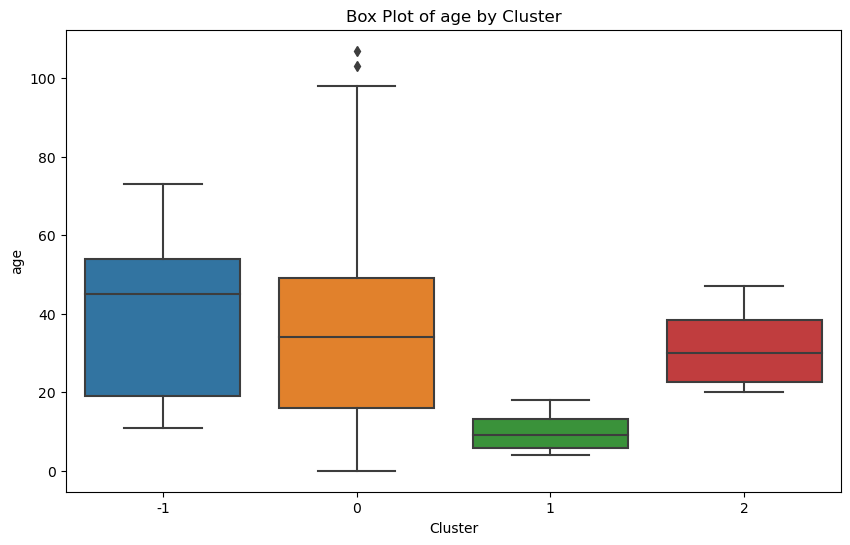

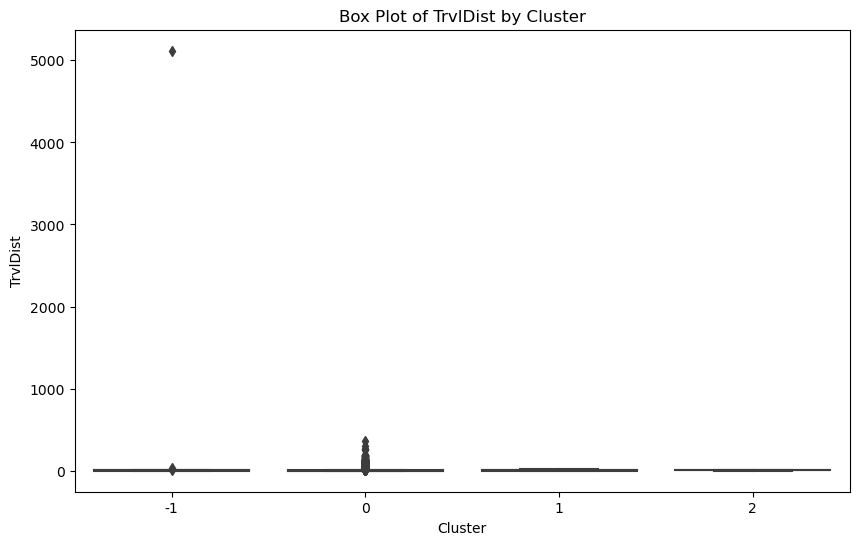

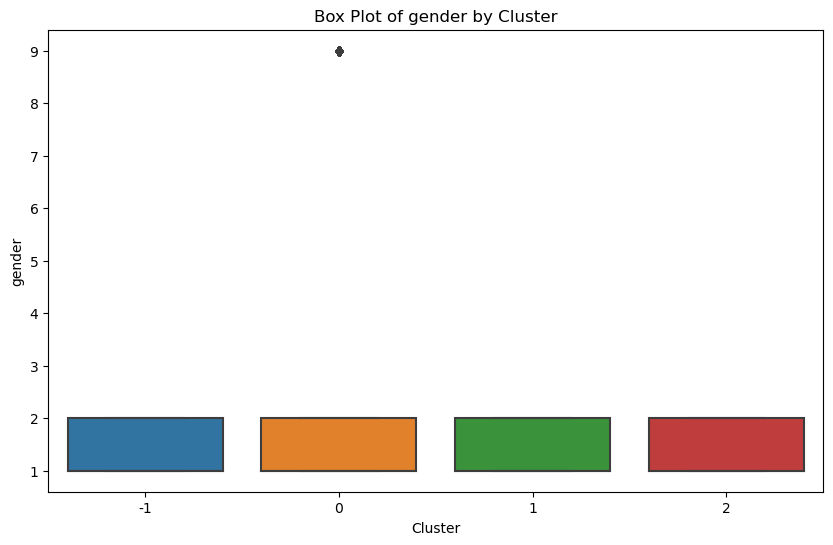

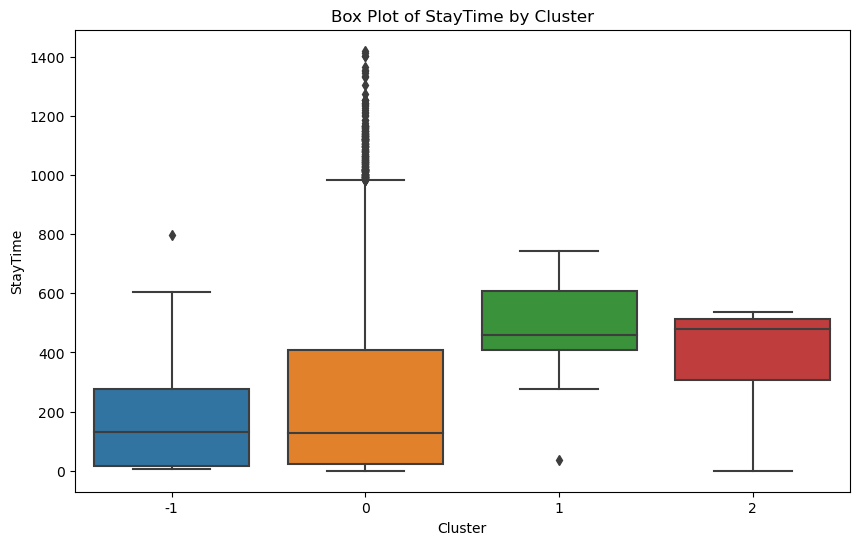

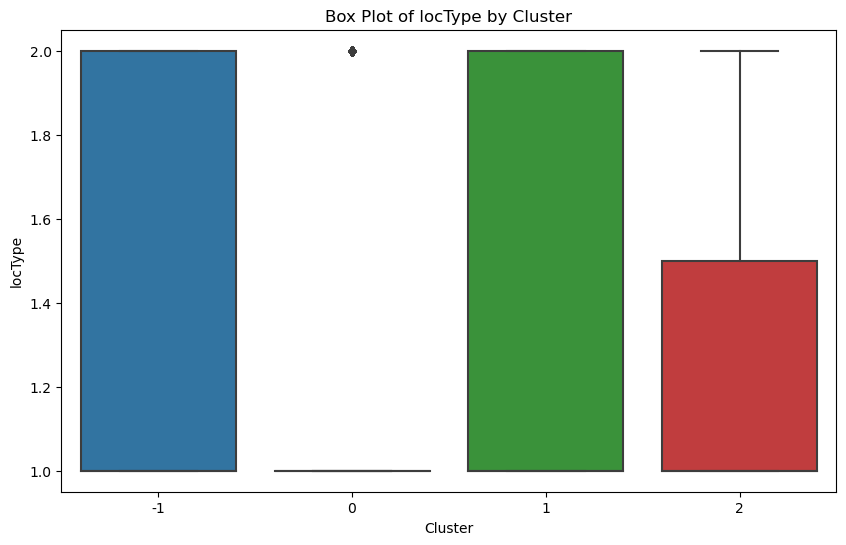

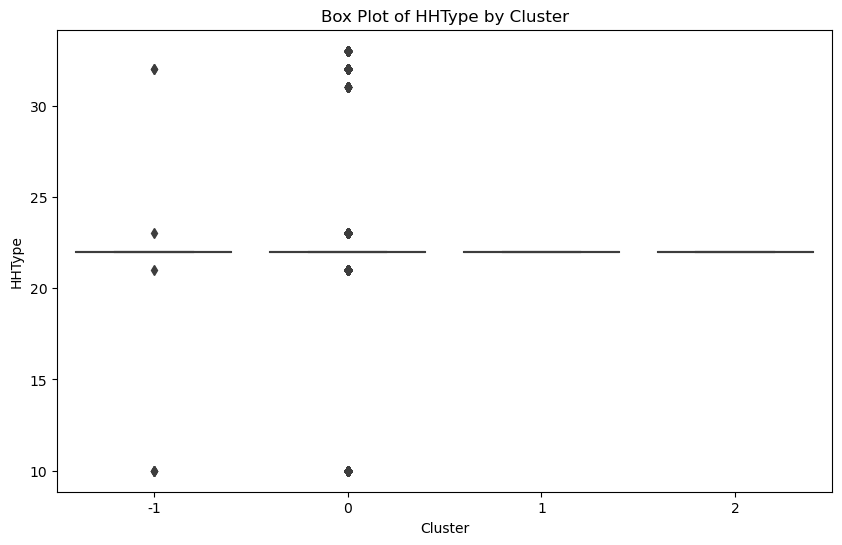

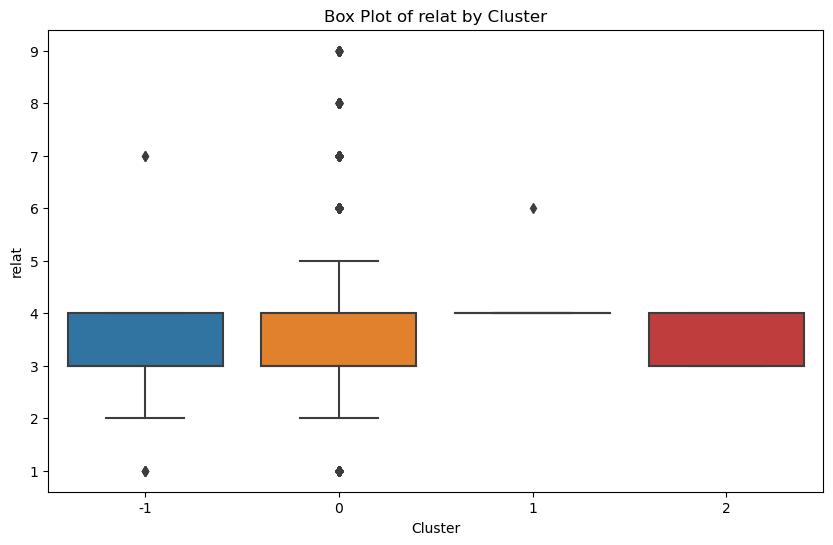

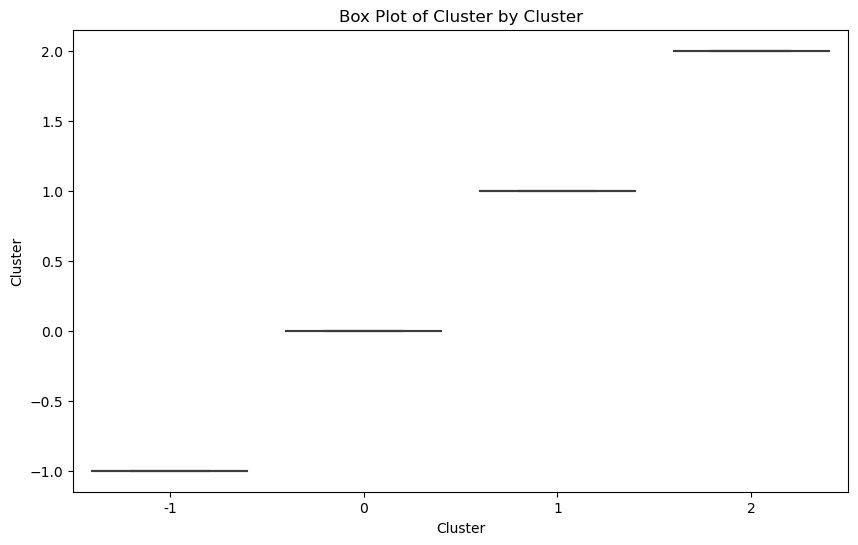

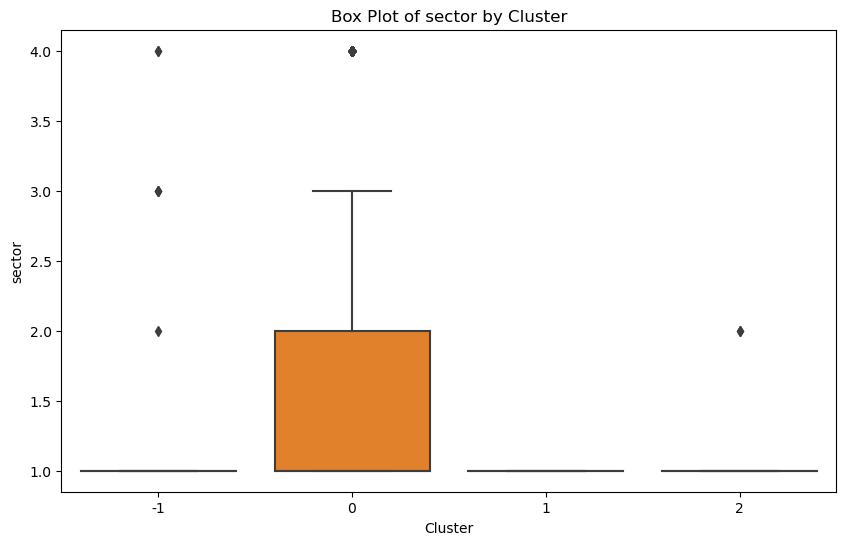

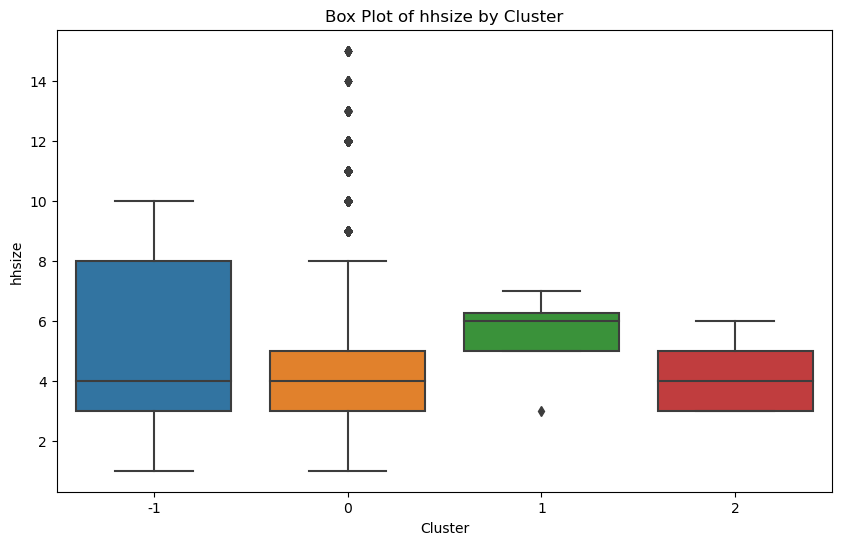

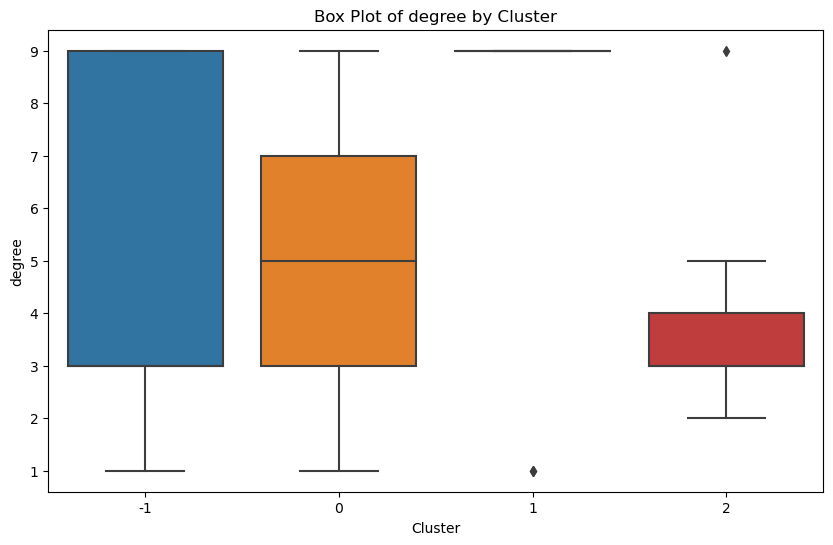

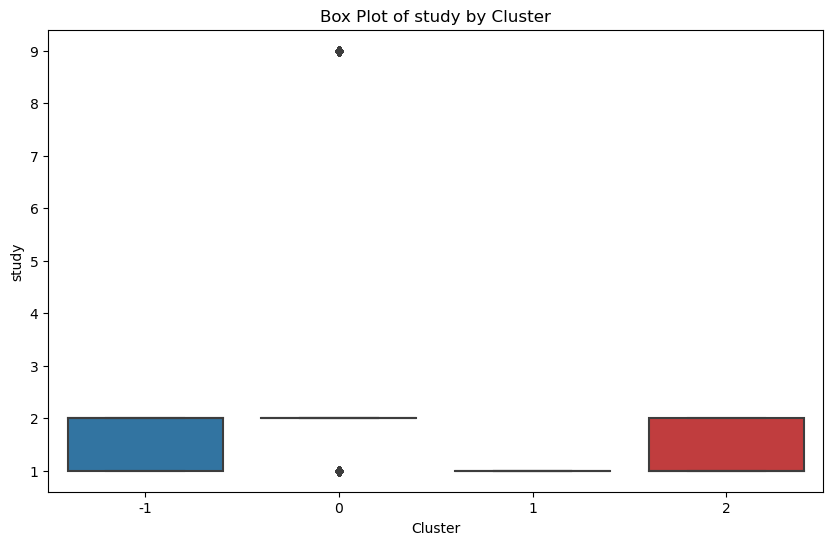

In [41]:
important_featuresDB = ['mainActivity','mainmode','age','TrvlDist','gender','StayTime','locType','HHType','relat', 'Cluster','sector','hhsize','degree','study']
for feature in important_featuresDB: 
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_imputedDB, x='Cluster', y=feature)
    plt.title(f'Box Plot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()



In [42]:
df_sampledDB['Cluster'] = clustersDB
important_featuresDB = ['mainActivity', 'mainmode', 'age', 'TrvlDist', 'gender', 'StayTime', 'locType', 'HHType', 'relat','sector', 'hhsize', 'degree', 'study']

# Create a summary table for each attribute according to the cluster
for feature in important_featuresDB:
    summary_tableDB = df_sampledDB.groupby('Cluster')[feature].value_counts(normalize=True).unstack(fill_value=0)
    print(f'\nSummary Table for {feature} by Cluster:')
    print(summary_tableDB)



Summary Table for mainActivity by Cluster:
mainActivity        1         2         3         4         5       6   \
Cluster                                                                  
-1            0.160000  0.120000  0.160000  0.200000  0.080000  0.1200   
 0            0.353235  0.091513  0.053118  0.107848  0.076131  0.0798   
 1            0.500000  0.000000  0.000000  0.500000  0.000000  0.0000   
 2            0.545455  0.090909  0.090909  0.090909  0.000000  0.0000   

mainActivity        7        8         9         10        11        12  
Cluster                                                                  
-1            0.000000  0.04000  0.080000  0.000000  0.040000  0.000000  
 0            0.056311  0.01592  0.039224  0.014308  0.108585  0.004007  
 1            0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  
 2            0.090909  0.00000  0.000000  0.000000  0.000000  0.090909  

Summary Table for mainmode by Cluster:
mainmode        1         2

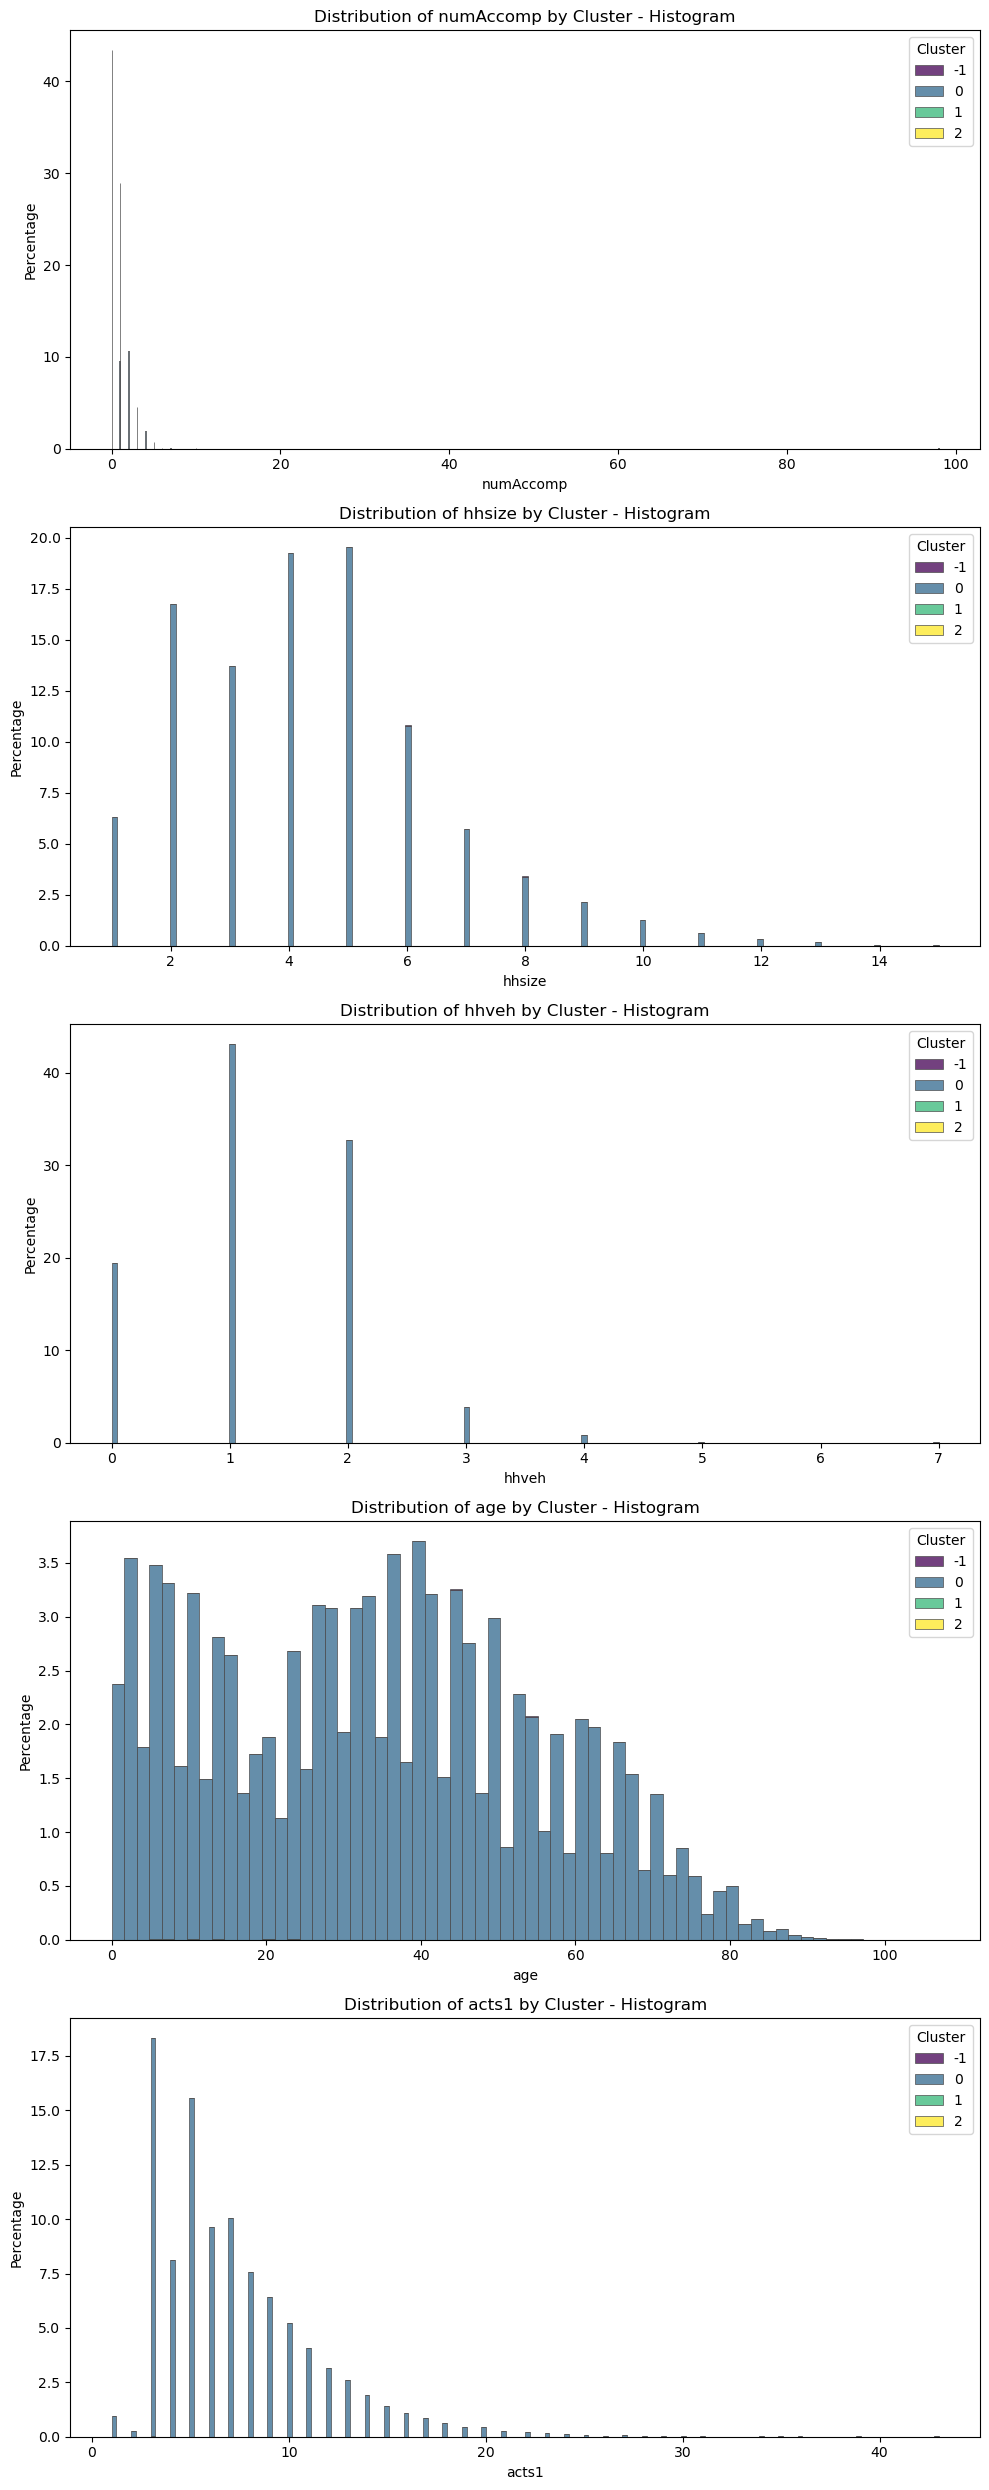

In [43]:
important_featuresDB = ['numAccomp','hhsize', 'hhveh', 'age', 'acts1']
num_plotsDB = len(important_featuresDB)
fig, axs = plt.subplots(num_plotsDB, 1, figsize=(10, 5 * num_plotsDB), squeeze=False)

for i, feature in enumerate(important_featuresDB):
    sns.histplot(data=df_sampledDB, x=feature, hue='Cluster', multiple="stack", palette="viridis", edgecolor=".3", linewidth=.5, stat='percent', ax=axs[i, 0])
    axs[i, 0].set_title(f'Distribution of {feature} by Cluster - Histogram')
    axs[i, 0].set_xlabel(feature)
    axs[i, 0].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

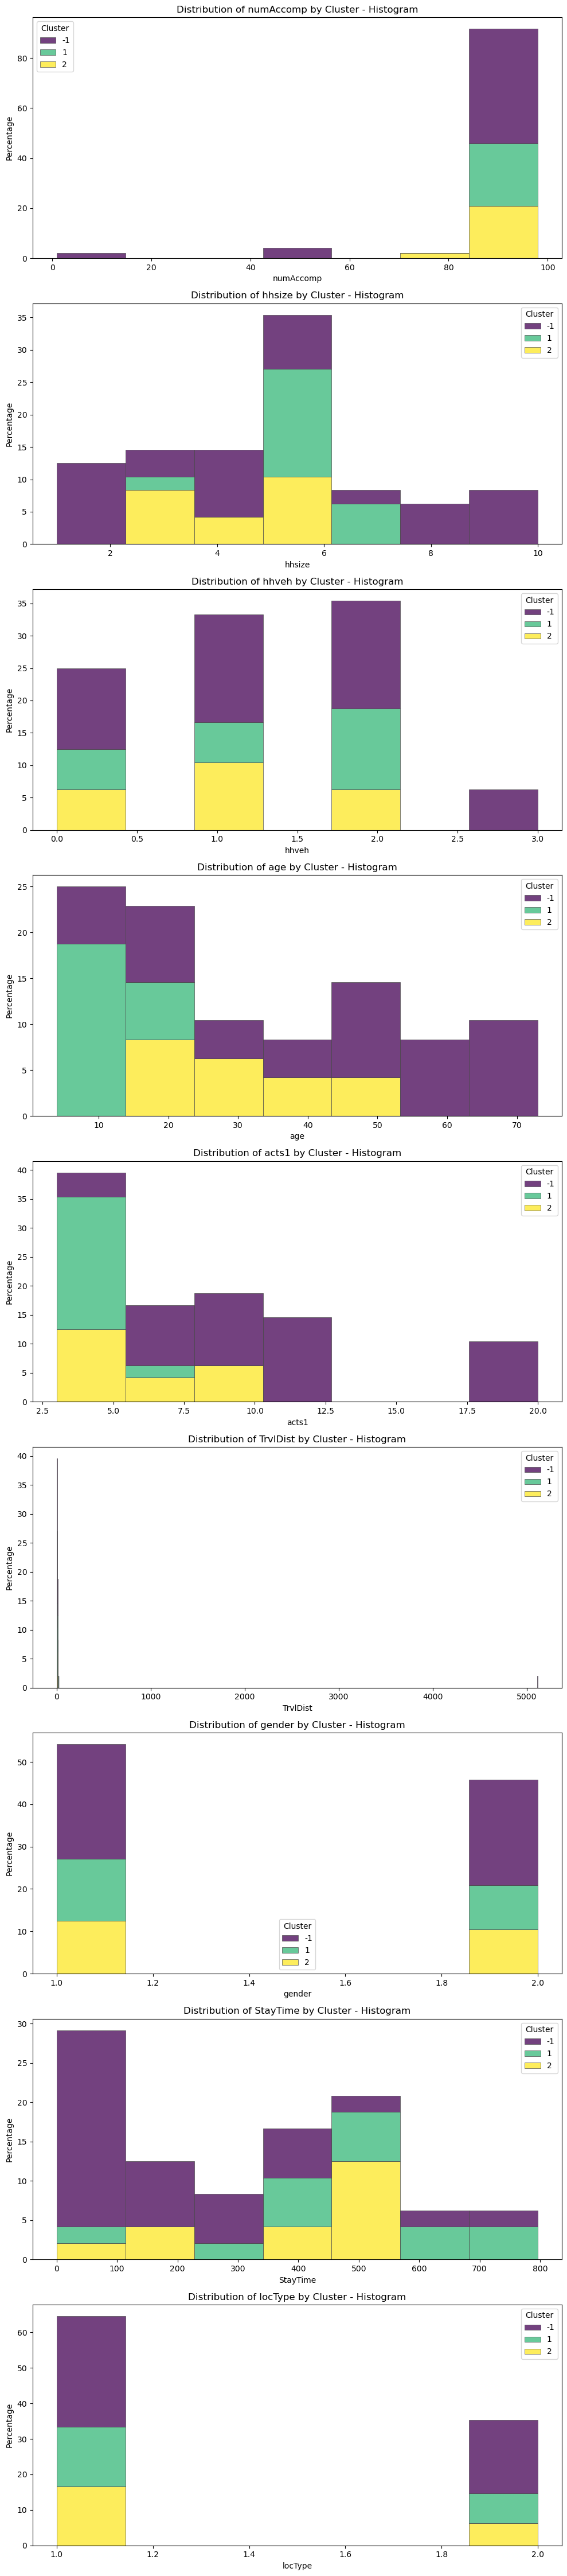

In [44]:
#We will also show without cluster 0 to see the data
important_featuresDB = ['numAccomp', 'hhsize', 'hhveh', 'age', 'acts1', 'TrvlDist', 'gender', 'StayTime', 'locType',]
df_filteredDB = df_sampledDB[df_sampledDB['Cluster'] != 0]

num_plotsDB = len(important_featuresDB)
fig, axs = plt.subplots(num_plotsDB, 1, figsize=(10, 5 * num_plotsDB), squeeze=False)
for i, feature in enumerate(important_featuresDB):
    sns.histplot(data=df_filteredDB, x=feature, hue='Cluster', multiple="stack", palette="viridis", edgecolor=".3", linewidth=.5, stat='percent', ax=axs[i, 0])
    axs[i, 0].set_title(f'Distribution of {feature} by Cluster - Histogram')
    axs[i, 0].set_xlabel(feature)
    axs[i, 0].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

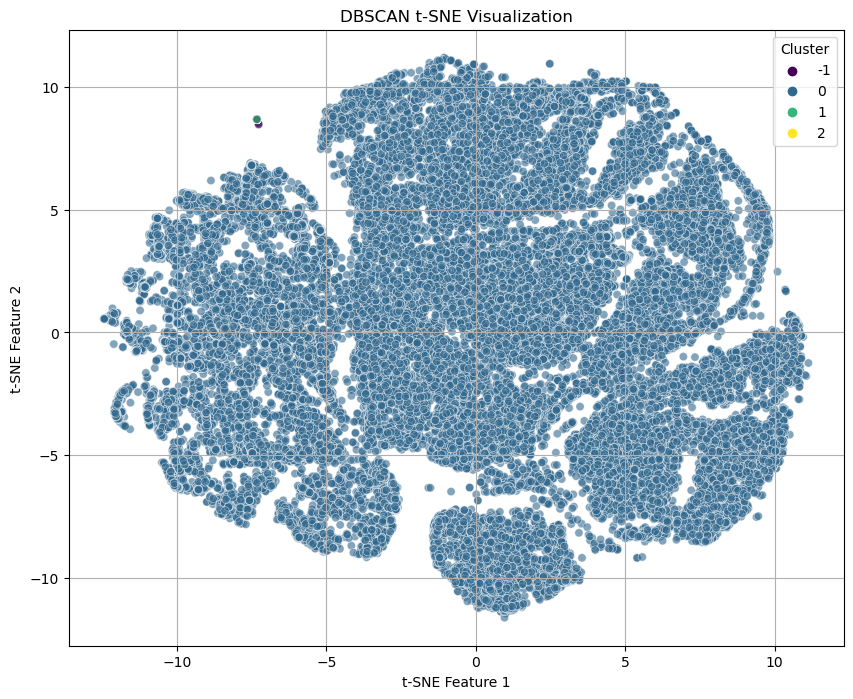

In [45]:
### CODE BY GPT### 
tsneDB = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=300)
df_tsneDB = tsneDB.fit_transform(df_denseDB)
df_tsneDB = pd.DataFrame(df_tsneDB, columns=['TSNE1', 'TSNE2'])
df_tsneDB['Cluster'] = clustersDB

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=df_tsneDB, palette='viridis', alpha=0.6, legend="full")
plt.title('DBSCAN t-SNE Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## K-means

In [47]:
df.head()

mainActivity  mainmode  numAccomp  TrvlDist  StayTime  locType  sector  \
0             5         1        1.0  0.285412   26.4000        1       1   
1             5         1        1.0  0.192655   62.0167        1       1   
2             1         1        1.0  0.363027  184.9670        1       1   
3             3        10        1.0  1.395220   63.0000        1       1   
4             5        10        1.0  0.290583  101.0170        1       1   

   hhsize  hhveh  HHType  relat  gender   age  degree  study  mlic  acts1  
0       2      1      23      4       2  33.0     5.0    2.0   2.0    9.0  
1       2      1      23      4       2  33.0     5.0    2.0   2.0    9.0  
2       2      1      23      4       2  33.0     5.0    2.0   2.0    9.0  
3       2      1      23      4       2  33.0     5.0    2.0   2.0    9.0  
4       2      1      23      4       2  33.0     5.0    2.0   2.0    9.0

In [48]:
# Handling missing values
imputer = SimpleImputer(strategy='constant', fill_value=9)
df= pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651865 entries, 0 to 651864
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   mainActivity  651865 non-null  float64
 1   mainmode      651865 non-null  float64
 2   numAccomp     651865 non-null  float64
 3   TrvlDist      651865 non-null  float64
 4   StayTime      651865 non-null  float64
 5   locType       651865 non-null  float64
 6   sector        651865 non-null  float64
 7   hhsize        651865 non-null  float64
 8   hhveh         651865 non-null  float64
 9   HHType        651865 non-null  float64
 10  relat         651865 non-null  float64
 11  gender        651865 non-null  float64
 12  age           651865 non-null  float64
 13  degree        651865 non-null  float64
 14  study         651865 non-null  float64
 15  mlic          651865 non-null  float64
 16  acts1         651865 non-null  float64
dtypes: float64(17)
memory usage: 84.5 MB


#### "The elbow" (wcss) method for choosing the amount of clusters


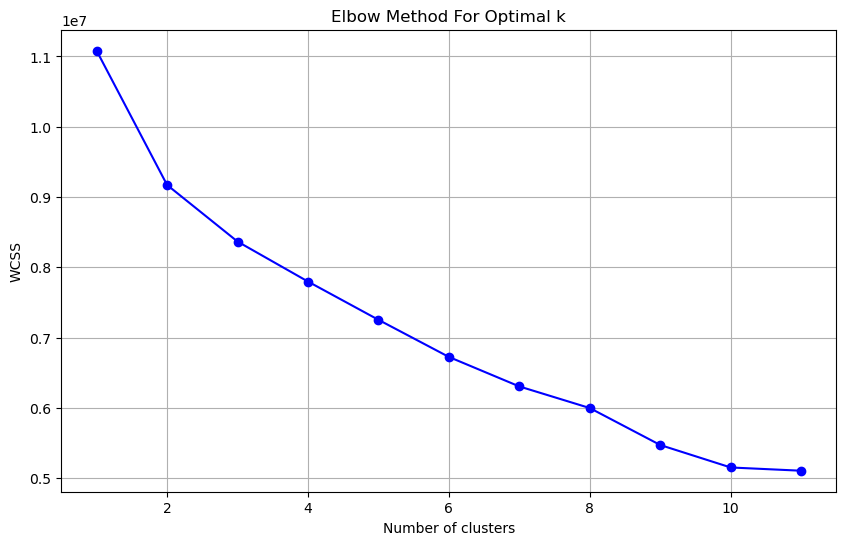

In [51]:
imputer = SimpleImputer(strategy='constant', fill_value=9)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)
cluster_range = range(1, 12)
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


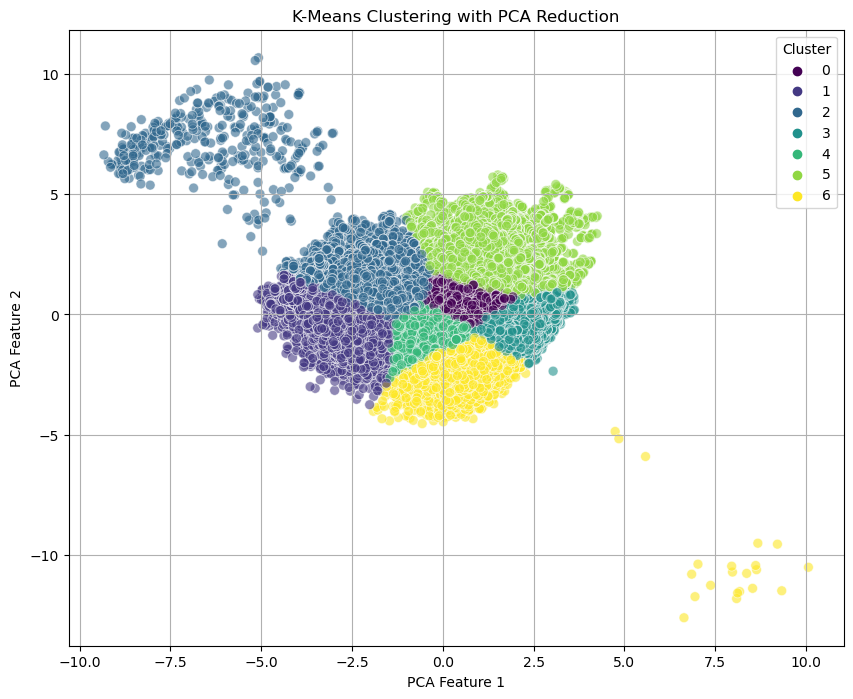

In [52]:
# We will take 10 percent of the data because runtime considerations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

df_prepared = preprocessor.fit_transform(df_imputed).toarray()  # המרת הנתונים לצורה צפופה אם יש צורך

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_prepared)

kmeans = KMeans(
    n_clusters=7,
    init="k-means++",
    max_iter=300,
    n_init=50,
    tol=1e-4,
    random_state=42
)
clusters = kmeans.fit_predict(df_pca)

# Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.6)
plt.title('K-Means Clustering with PCA Reduction')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [53]:
# Amount of values ​​per cluster
df_imputed['Cluster'] = clusters
cluster_counts = df_imputed['Cluster'].value_counts().sort_index()
print("Number of values in each cluster:")
print(cluster_counts)

Number of values in each cluster:
Cluster
0    139025
1    108889
2     79751
3    103843
4     90973
5     70049
6     59335
Name: count, dtype: int64


#### We will analyze the clusters and try to understand why cluster 2 is unusual

In [55]:
important_features = ['mainActivity','mainmode','age','TrvlDist','gender','StayTime','locType','HHType','relat', 'Cluster','sector','hhsize','degree','study']

#### density distribution

In [57]:
df_sampled = df

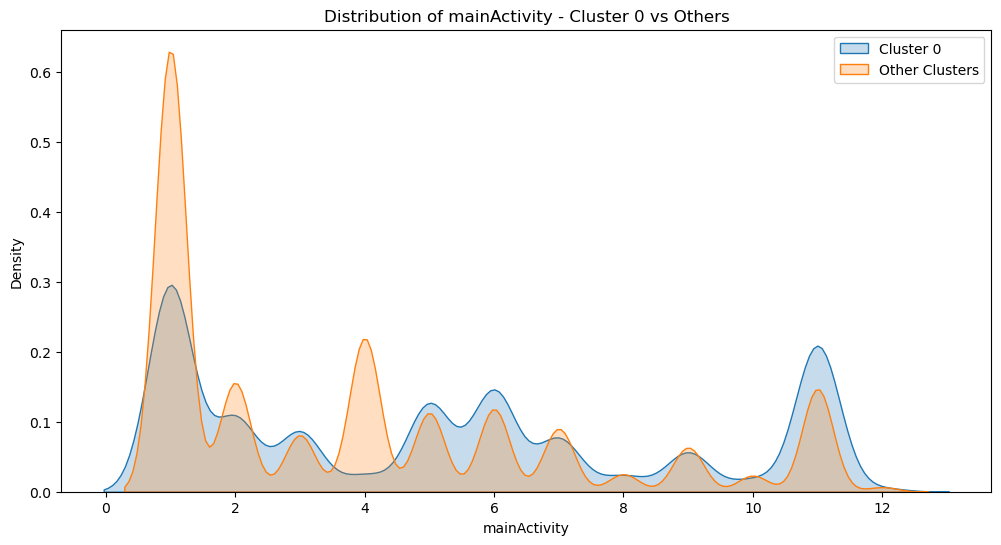

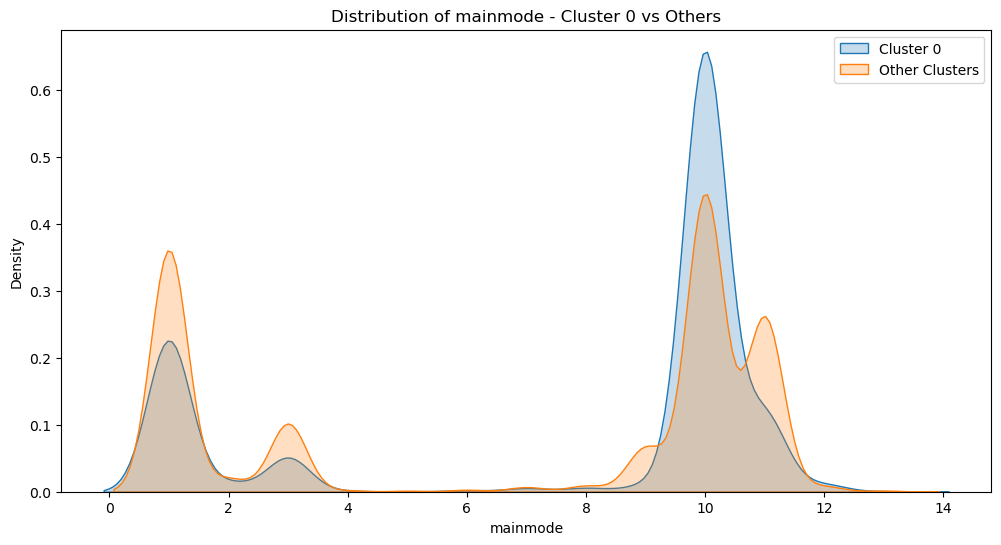

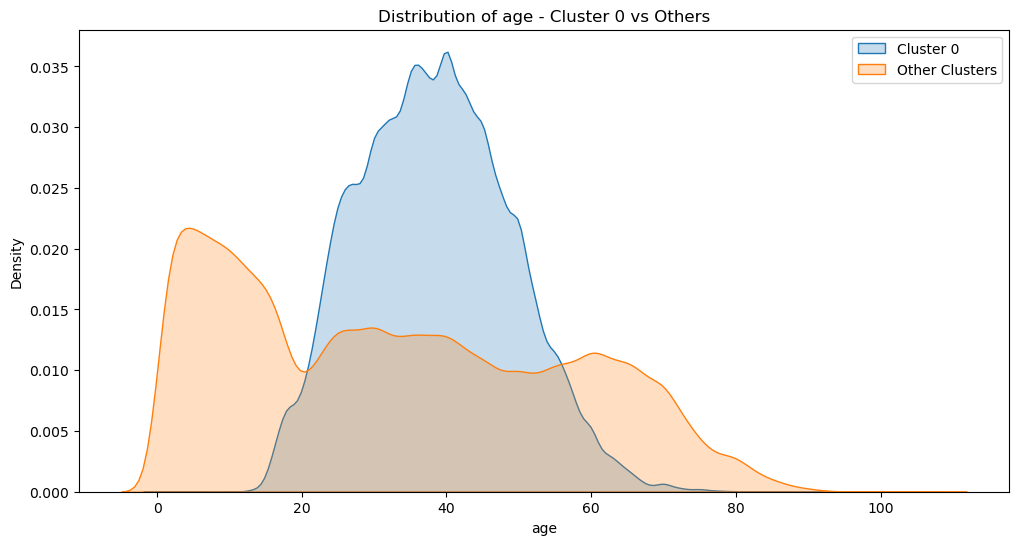

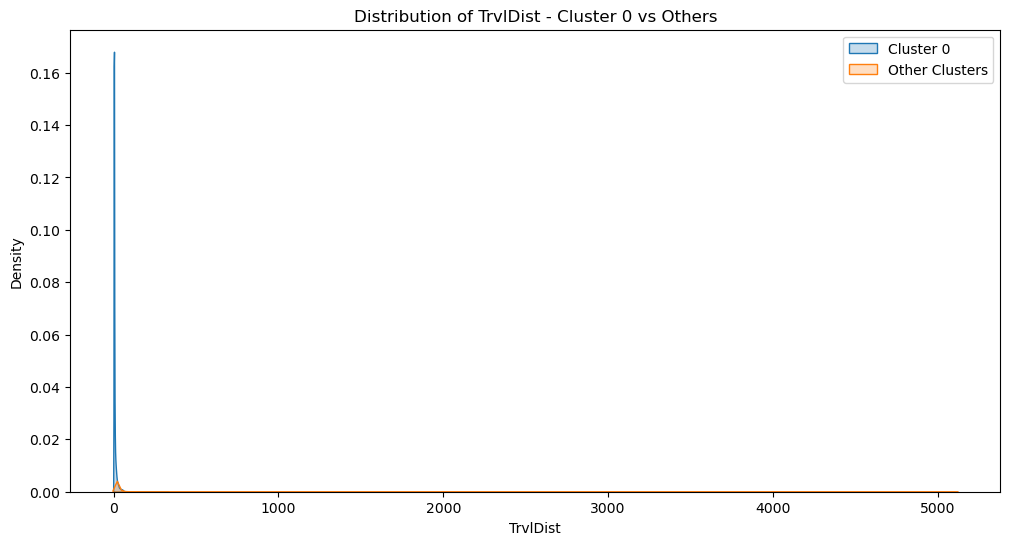

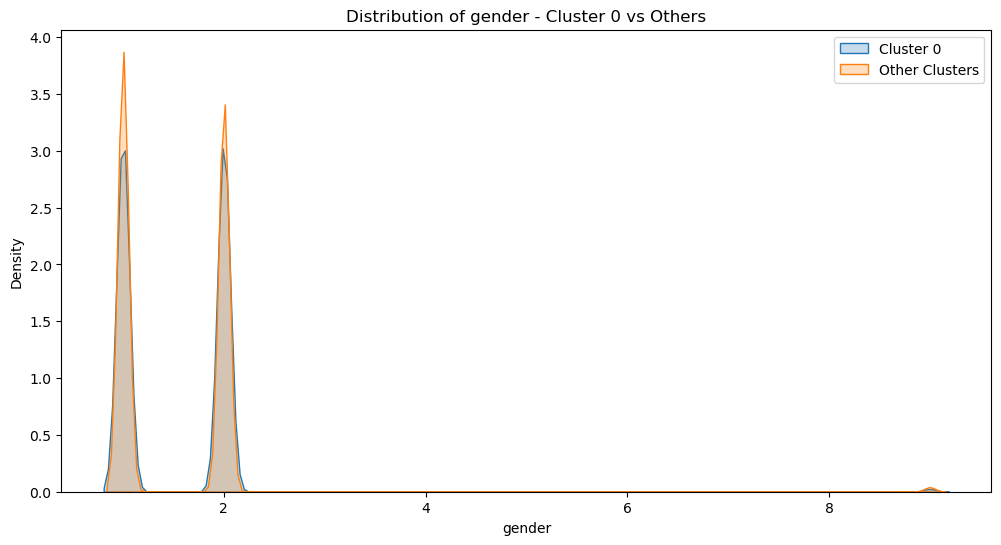

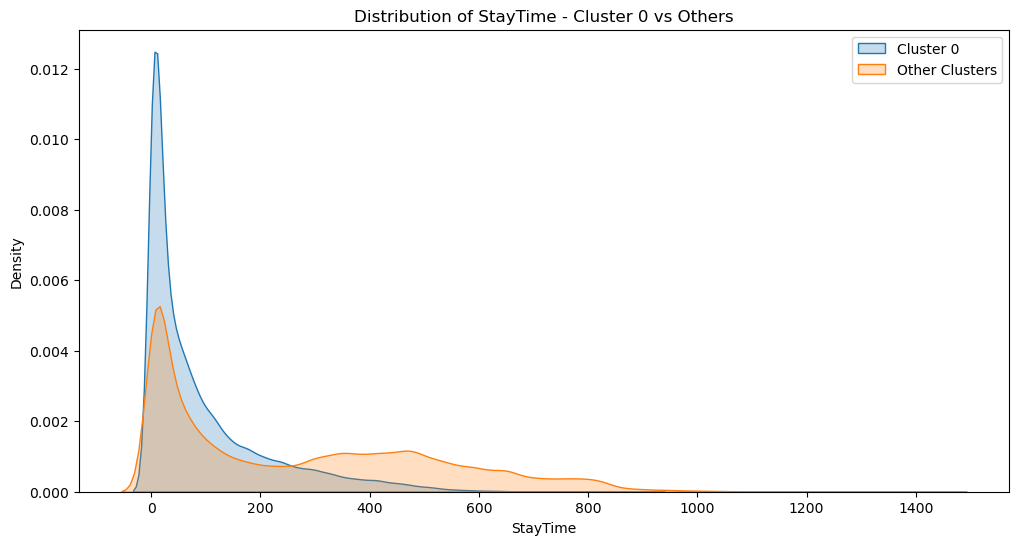

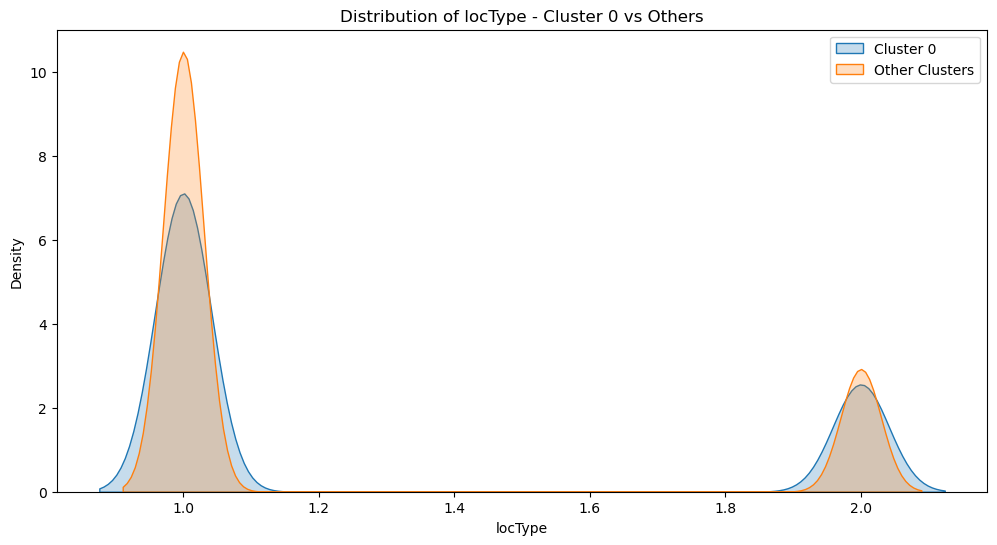

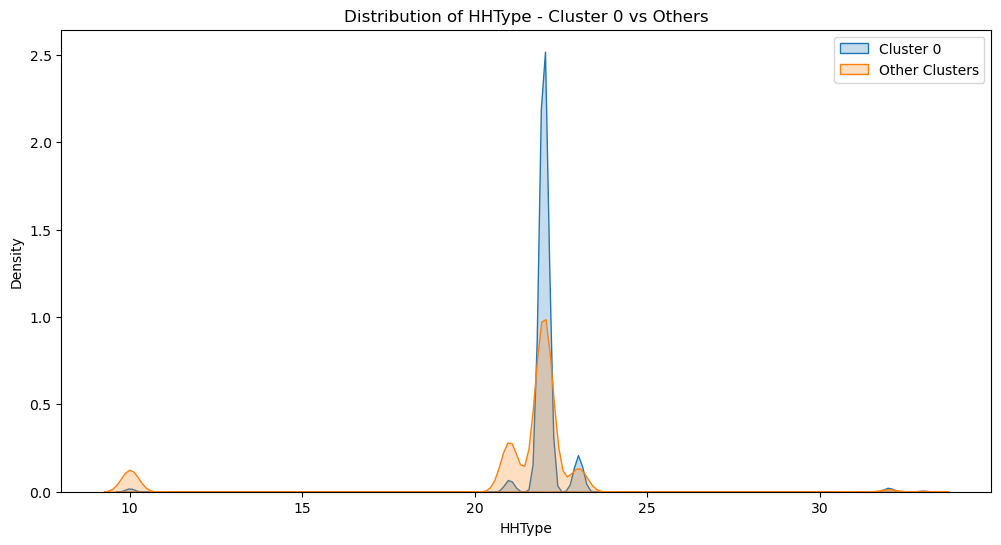

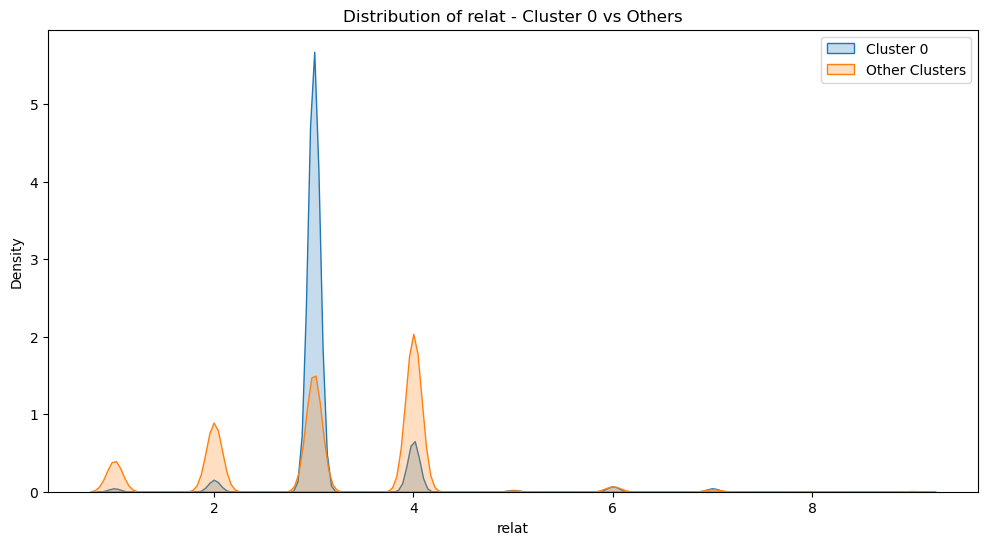

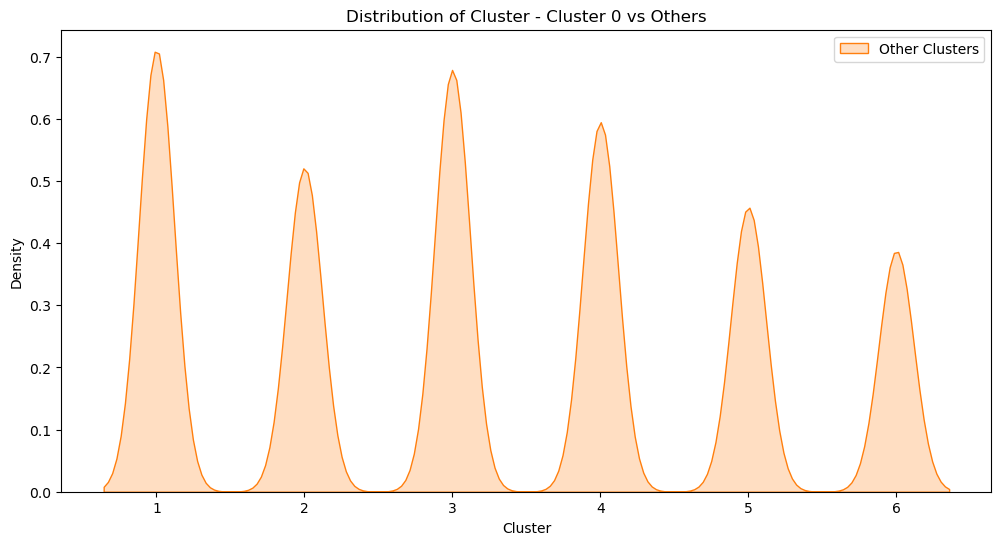

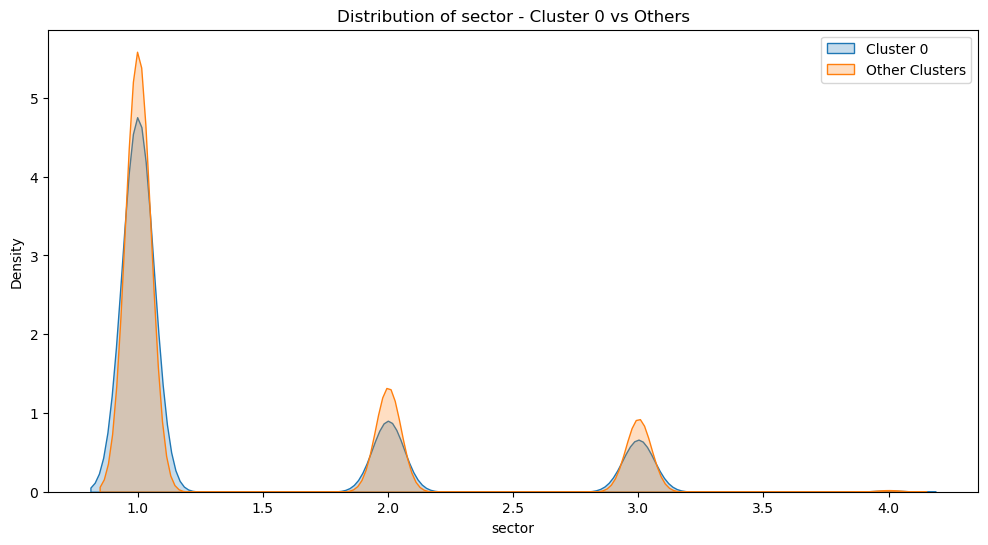

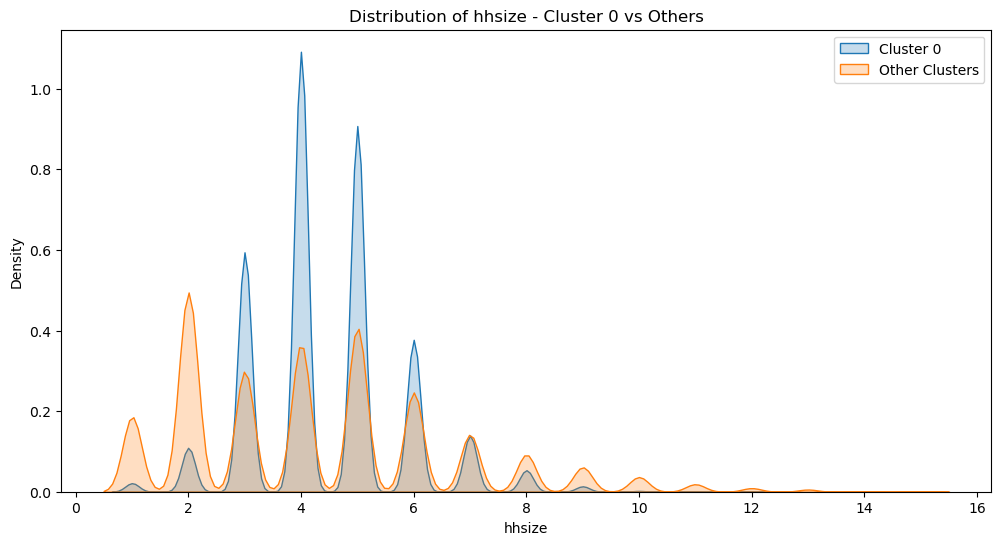

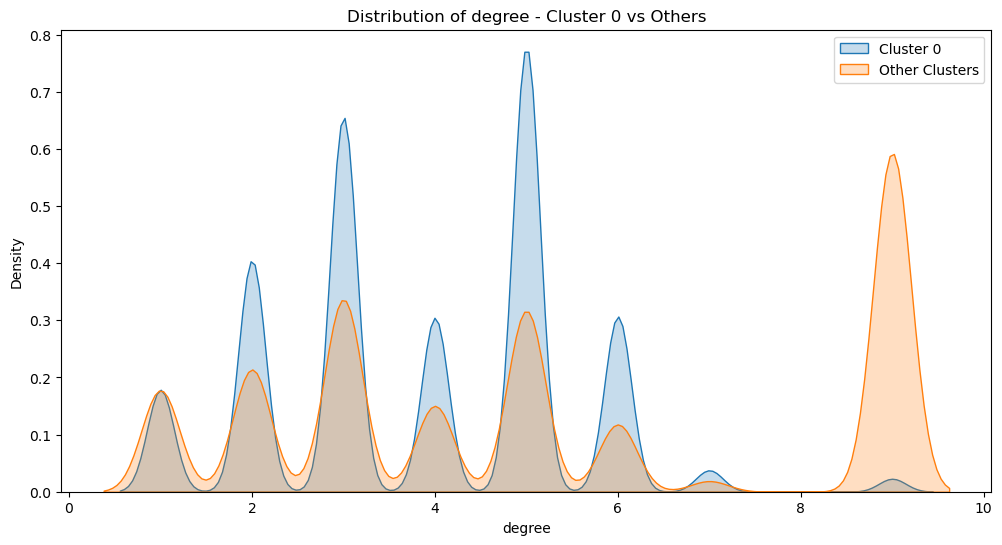

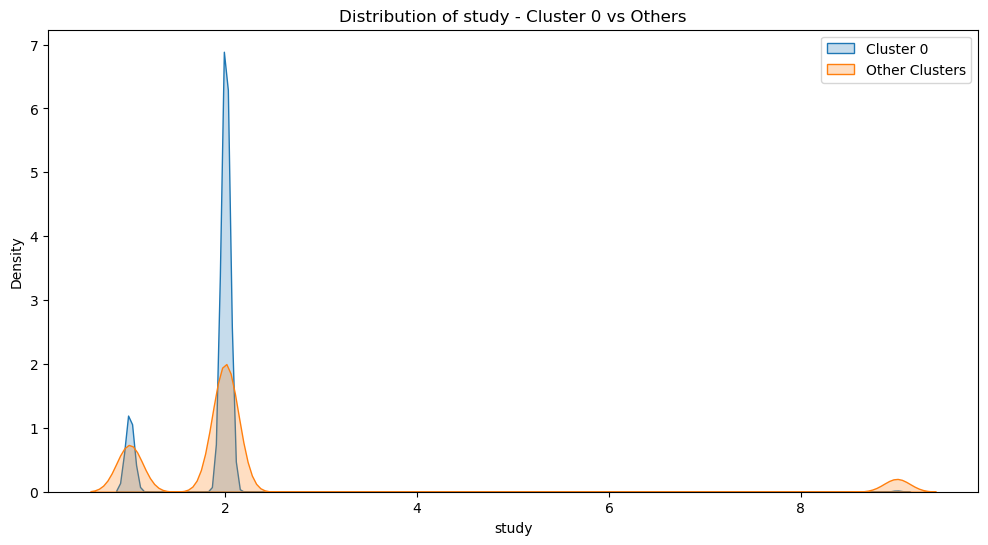

In [58]:
df_sampled['Cluster'] = clusters 
cluster_0 = df_sampled[df_sampled['Cluster'] == 0]
other_clusters = df_sampled[df_sampled['Cluster'] != 0]
# Visualization
for feature in important_features:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(cluster_0[feature], label='Cluster 0', fill=True)
    sns.kdeplot(other_clusters[feature], label='Other Clusters', fill=True)
    plt.title(f'Distribution of {feature} - Cluster 0 vs Others')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

#### Statistics about cluster 2

In [60]:
cluster_2 = df_sampled[df_sampled['Cluster'] == 2]
other_clusters = df_sampled[df_sampled['Cluster'] != 2]

important_features = ['mainActivity', 'mainmode', 'age', 'TrvlDist', 'gender','StayTime', 'locType', 'HHType', 'relat', 'sector', 'hhsize', 'degree', 'study']


print("Statistics for Cluster 2:")
print(cluster_0[important_features].describe())
print("\nStatistics for Other Clusters:")
print(other_clusters[important_features].describe())


Statistics for Cluster 2:
        mainActivity       mainmode            age       TrvlDist  \
count  139025.000000  139025.000000  139025.000000  139025.000000   
mean        5.235634       7.793152      38.352282       5.559813   
std         3.677199       3.899828      10.535591      12.219446   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000       3.000000      30.000000       0.451984   
50%         5.000000      10.000000      38.000000       1.323440   
75%         8.000000      10.000000      46.000000       4.628200   
max        12.000000      13.000000      96.000000     328.565000   

              gender       StayTime        locType        HHType  \
count  139025.000000  139025.000000  139025.000000  139025.00000   
mean        1.524352      93.004365       1.264506      22.07175   
std         0.683024     117.714657       0.441072       1.44364   
min         1.000000       0.000000       1.000000      10.00000   
25%         

#### Average calculation 

In [62]:
clusters_of_interest = [0, 1, 2, 3, 4, 5, 6]  
df_filtered = df_sampled[df_sampled['Cluster'].isin(clusters_of_interest)]

important_features = ['age', 'TrvlDist', 'gender','StayTime', 'locType', 'hhsize',   'degree', 'study']

comparison_results = pd.DataFrame()

for feature in important_features:
    cluster_means = df_filtered.groupby('Cluster')[feature].mean()
    overall_mean = df_filtered[feature].mean()

    comparison_results.loc[feature, 'Overall Mean'] = overall_mean
    comparison_results.loc[feature, 'Cluster 2 Mean'] = cluster_means[2]

print("Summary of Mean Comparison between Cluster 2 and Overall:")
print(comparison_results)


Summary of Mean Comparison between Cluster 2 and Overall:
          Overall Mean  Cluster 2 Mean
age          34.182053       12.760617
TrvlDist      5.201001        3.086459
gender        1.514927        1.491856
StayTime    230.432780      123.707711
locType       1.228013        1.152036
hhsize        4.310504        6.397149
degree        4.899976        6.899512
study         2.151765        2.404246


In [63]:
#Option to Focus on any a specific cluster
target_cluster = 2
cluster_stats = df_sampled[df_sampled['Cluster'] == target_cluster].describe()

# Calculate statistics for all other clusters
other_clusters_stats = df_sampled[df_sampled['Cluster'] != target_cluster].describe()

# Comparison between the clusters
comparison_stats = pd.DataFrame()
comparison_stats['Target Cluster Mean'] = cluster_stats.loc['mean']
comparison_stats['Other Clusters Mean'] = other_clusters_stats.loc['mean']
comparison_stats['Difference in Means'] = comparison_stats['Target Cluster Mean'] - comparison_stats['Other Clusters Mean']

print("Summary of Mean Comparison between target_cluster and Overall:")
print(comparison_stats)


Summary of Mean Comparison between target_cluster and Overall:
              Target Cluster Mean  Other Clusters Mean  Difference in Means
mainActivity             5.943750             4.010730             1.933020
mainmode                 6.181390             7.224052            -1.042662
numAccomp                2.072627             0.746469             1.326158
TrvlDist                 3.086459             5.495762            -2.409303
StayTime               123.707711           245.309939          -121.602228
locType                  1.152036             1.238605            -0.086569
sector                   1.613597             1.371297             0.242301
hhsize                   6.397149             4.019632             2.377516
hhveh                    1.173164             1.241531            -0.068367
HHType                  22.044388            21.182504             0.861884
relat                    3.928966             3.046498             0.882469
gender                   

#### Distribution for categorical values

In [65]:
# Categorical features to analyze
categorical_features =['mainActivity','mainmode','locType','HHType','sector','relat','gender','degree','study','mlic',]

# Create plots for each feature
for feature in categorical_features:
    cluster_summary = df_sampled.pivot_table(
        index='Cluster', 
        columns=feature, 
        aggfunc='size', 
        fill_value=0
    )
    cluster_summary = cluster_summary.div(cluster_summary.sum(axis=1), axis=0) * 100

    print(f"\nPercentage Distribution for {feature}:")
    print(cluster_summary.round(2))


Percentage Distribution for mainActivity:
mainActivity   1.0    2.0    3.0    4.0    5.0    6.0   7.0   8.0   9.0   \
Cluster                                                                    
0             25.42   8.97   7.34   1.98  10.76  12.39  6.49  1.92  4.83   
1             54.29   0.53   0.03  42.27   0.10   0.08  1.47  0.07  0.54   
2             26.06   1.89   0.62  14.43   6.70   5.11  8.43  1.85  7.50   
3             21.29   8.24  10.01   0.70  15.90  16.89  8.36  3.58  5.97   
4             51.24  22.54   1.76   7.62   2.88   3.03  4.83  0.74  2.82   
5             14.29   5.18  15.94   1.18  11.76  14.29  5.16  1.44  3.55   
6             59.03  21.86   1.79   2.10   2.84   2.95  4.34  1.18  2.60   

mainActivity  10.0   11.0  12.0  
Cluster                          
0             1.46  18.01  0.43  
1             0.08   0.45  0.08  
2             2.69  24.11  0.62  
3             2.74   5.76  0.55  
4             1.06   1.22  0.26  
5             0.66  25.85  0.70  


#### Visualization of values ​​to which the average is relevant

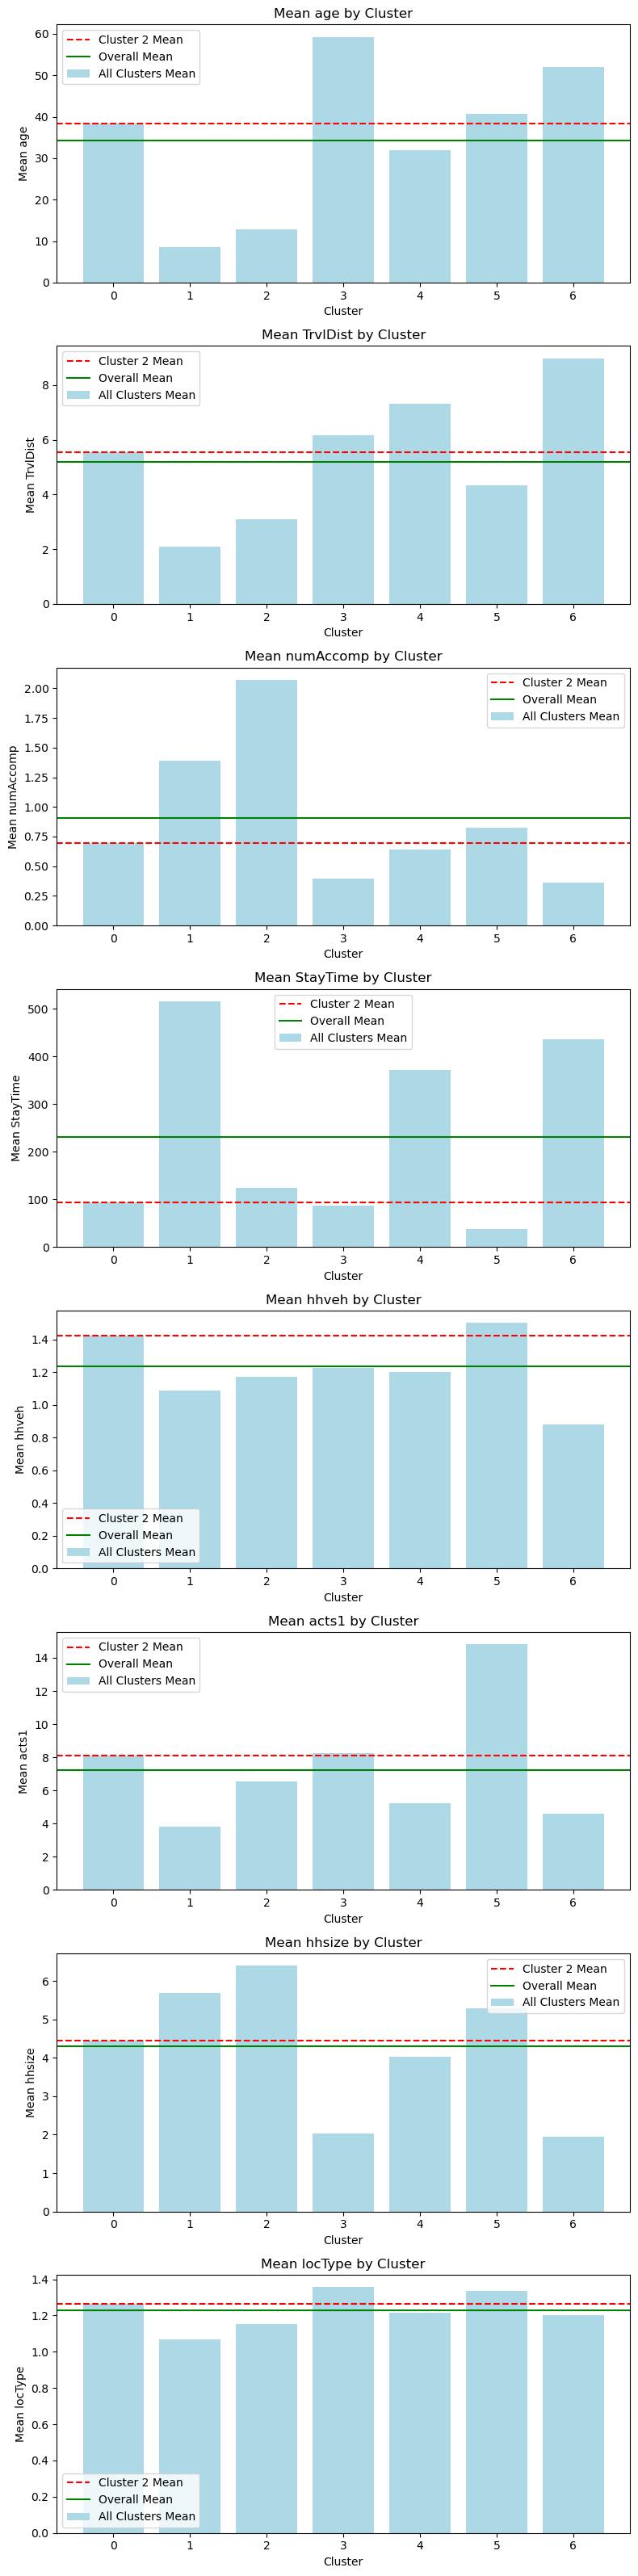

In [67]:
# Calculate only parameters to which the percentages are relevant
mean_features = ['age', 'TrvlDist','numAccomp','StayTime','hhveh','acts1','hhsize','locType']  

fig, ax = plt.subplots(len(mean_features), 1, figsize=(8, 4 * len(mean_features)))
for i, feature in enumerate(mean_features):
    group_means = df_sampled.groupby('Cluster')[feature].mean()
    cluster_0_mean = group_means.loc[0]
    overall_mean = df_sampled[feature].mean()
    # Visualization
    ax[i].bar(group_means.index, group_means.values, color='lightblue', label='All Clusters Mean')
    ax[i].axhline(cluster_0_mean, color='red', linestyle='--', label='Cluster 2 Mean')
    ax[i].axhline(overall_mean, color='green', linestyle='-', label='Overall Mean')
    ax[i].set_title(f'Mean {feature} by Cluster')
    ax[i].set_xlabel('Cluster')
    ax[i].set_ylabel(f'Mean {feature}')
    ax[i].legend()

plt.tight_layout()
plt.show()


#### Visualization of percentage distribution by cluster

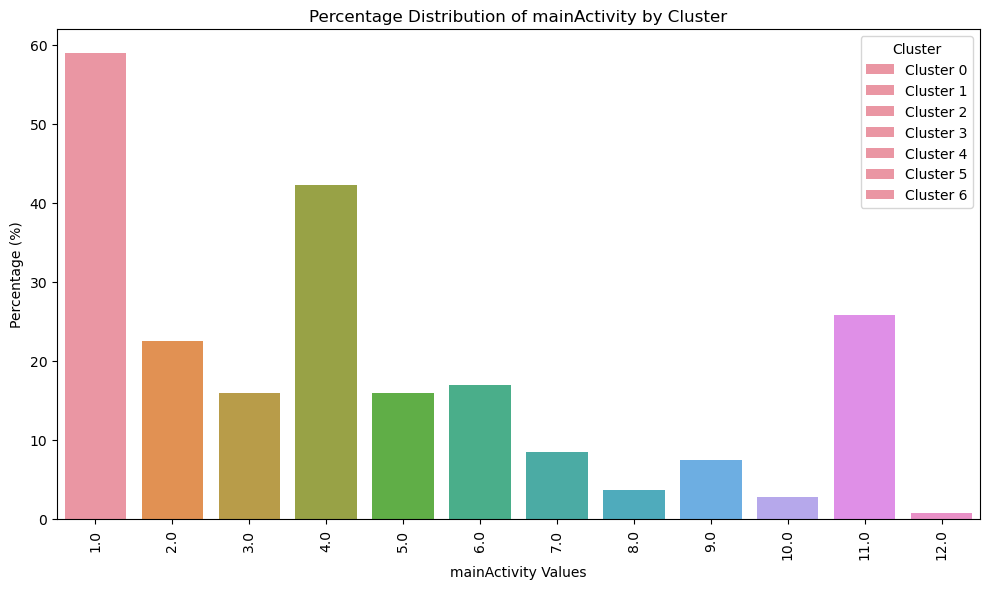

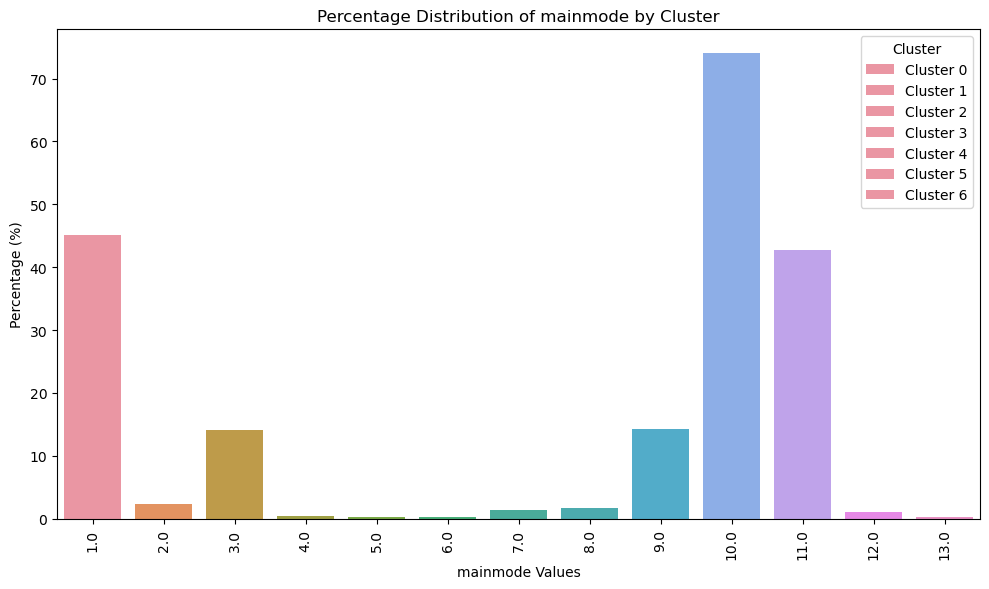

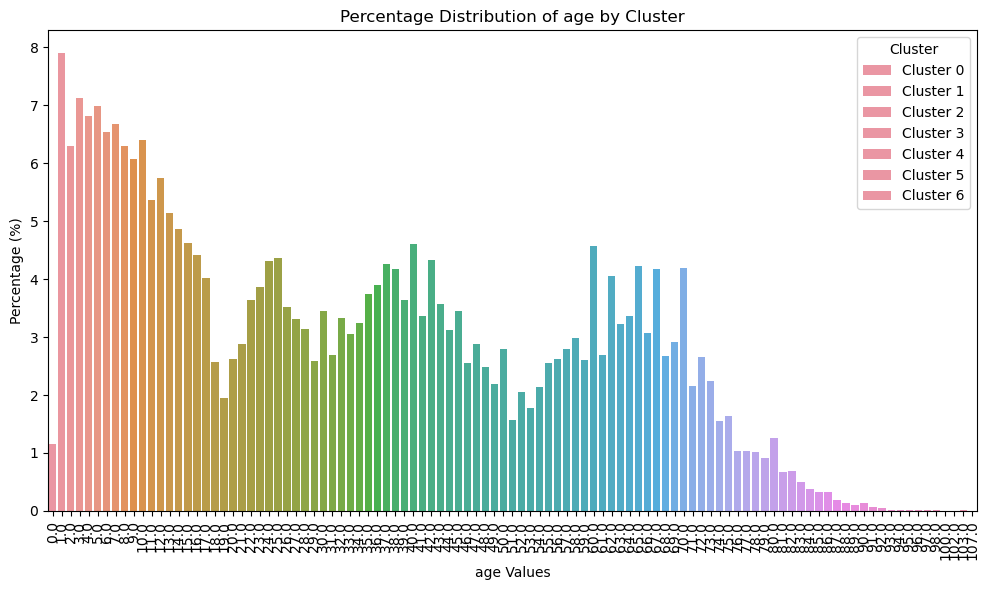

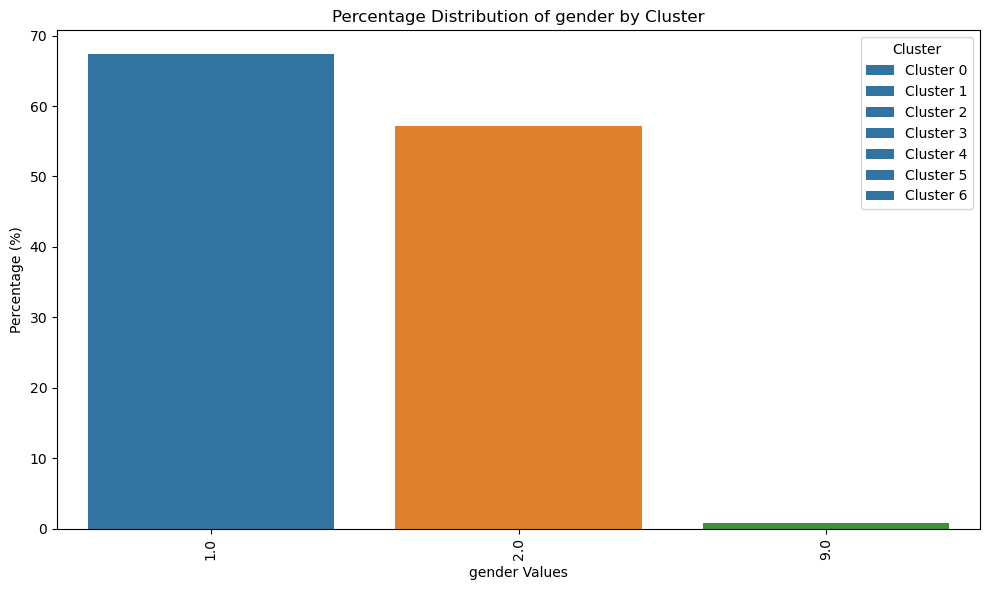

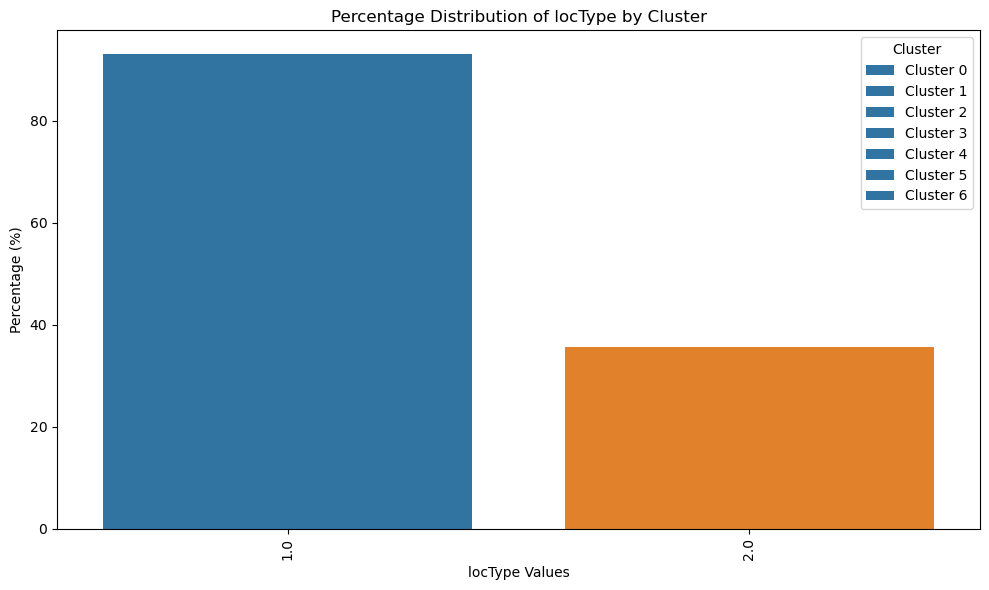

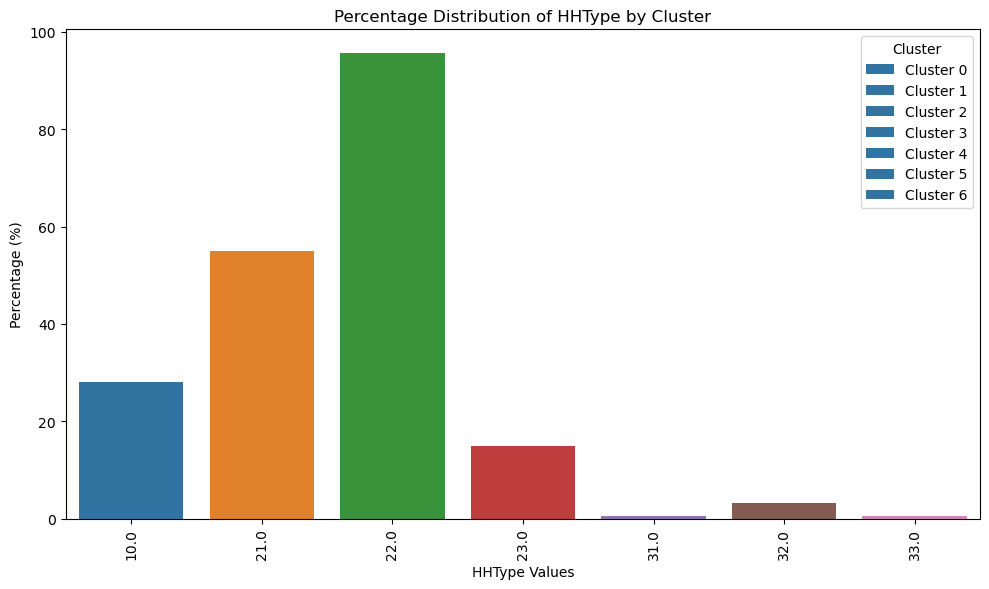

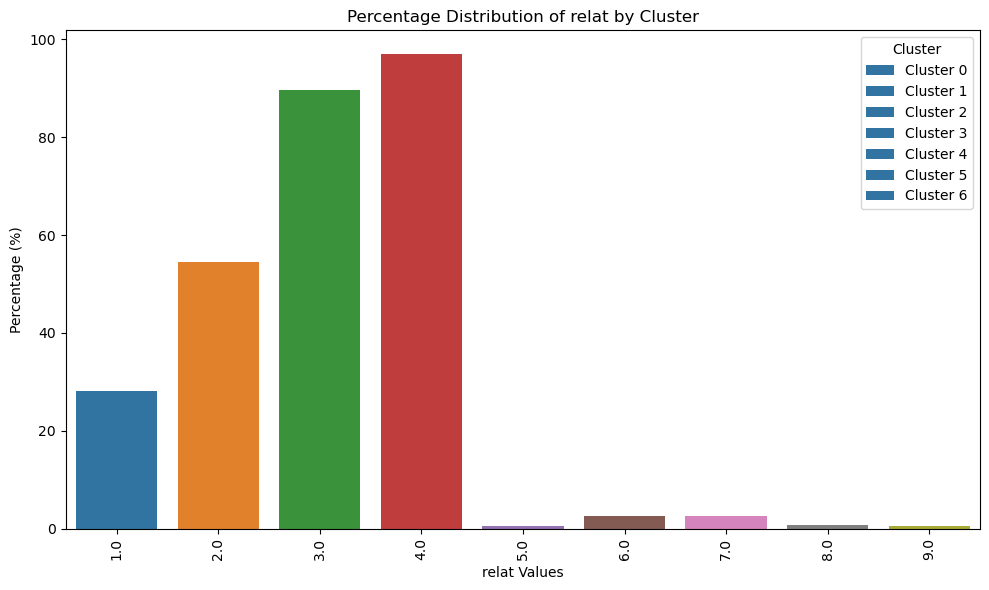

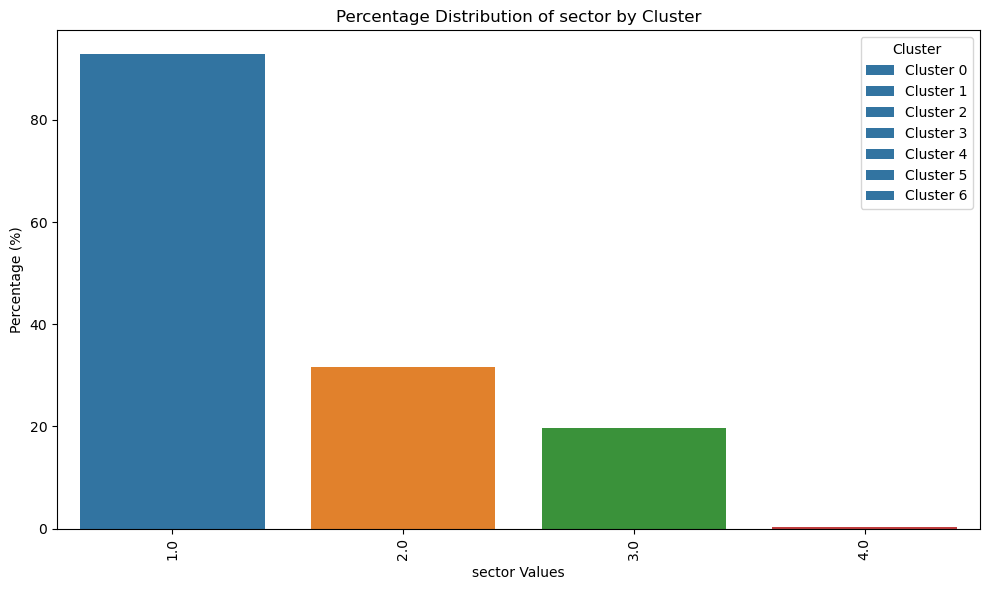

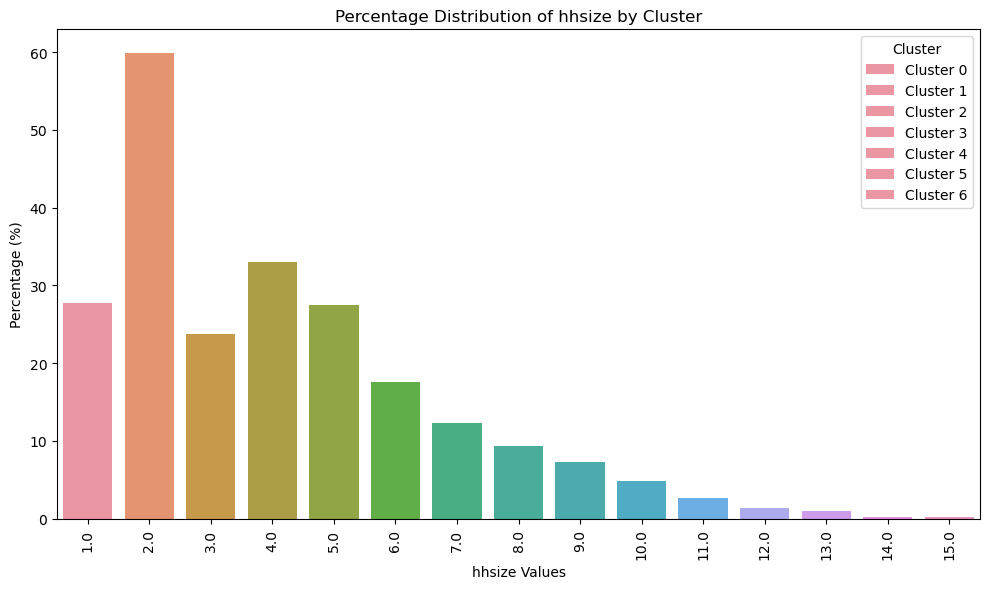

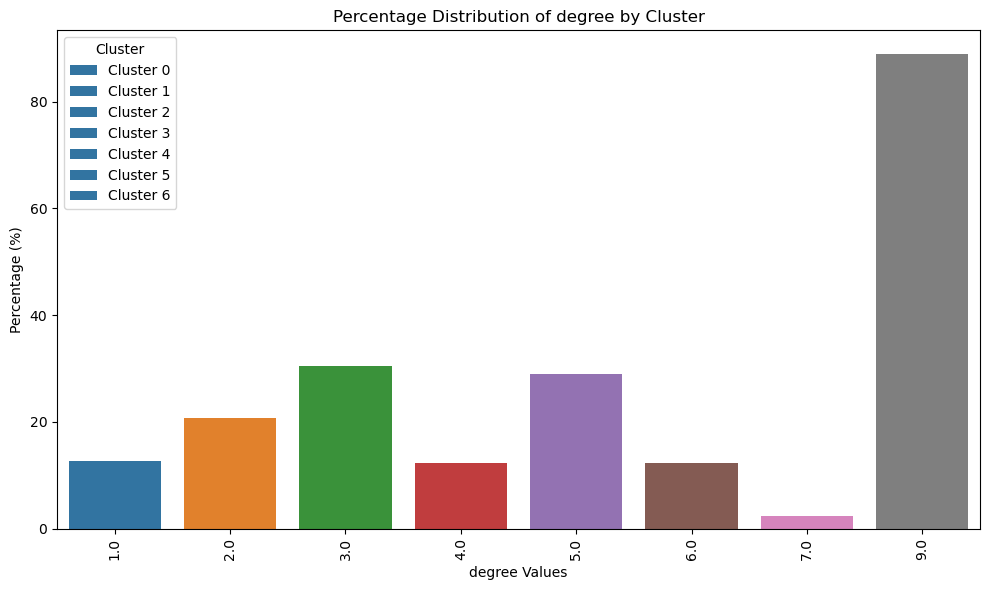

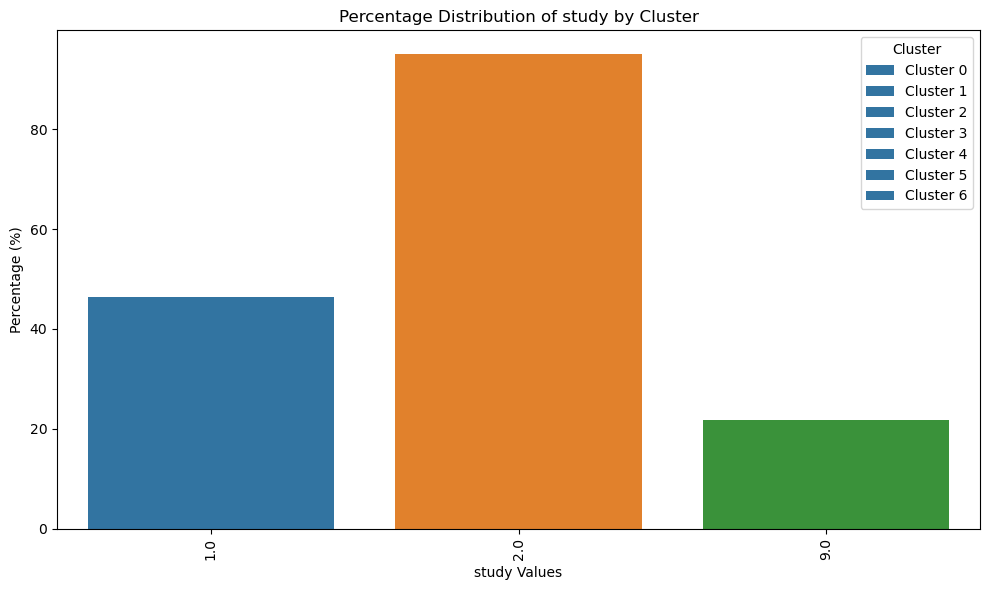

In [69]:
# We will remove pitchers with lots of discrete values
features_to_analyze = ['mainActivity', 'mainmode', 'age', 'gender', 'locType', 'HHType', 'relat', 'sector', 'hhsize','degree', 'study']

for feature in features_to_analyze:
    cluster_summary = df_sampled.pivot_table(index='Cluster', columns=feature, aggfunc='size', fill_value=0)
    cluster_summary = cluster_summary.div(cluster_summary.sum(axis=1), axis=0) * 100  

    plt.figure(figsize=(10, 6))
    for cluster in cluster_summary.index:
        sns.barplot(x=cluster_summary.columns, y=cluster_summary.loc[cluster], label=f'Cluster {cluster}')
    # Visualization
    plt.title(f'Percentage Distribution of {feature} by Cluster')
    plt.ylabel('Percentage (%)')
    plt.xlabel(f'{feature} Values')
    plt.legend(title='Cluster')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


#### We will also try EM, we got the same and evev worse

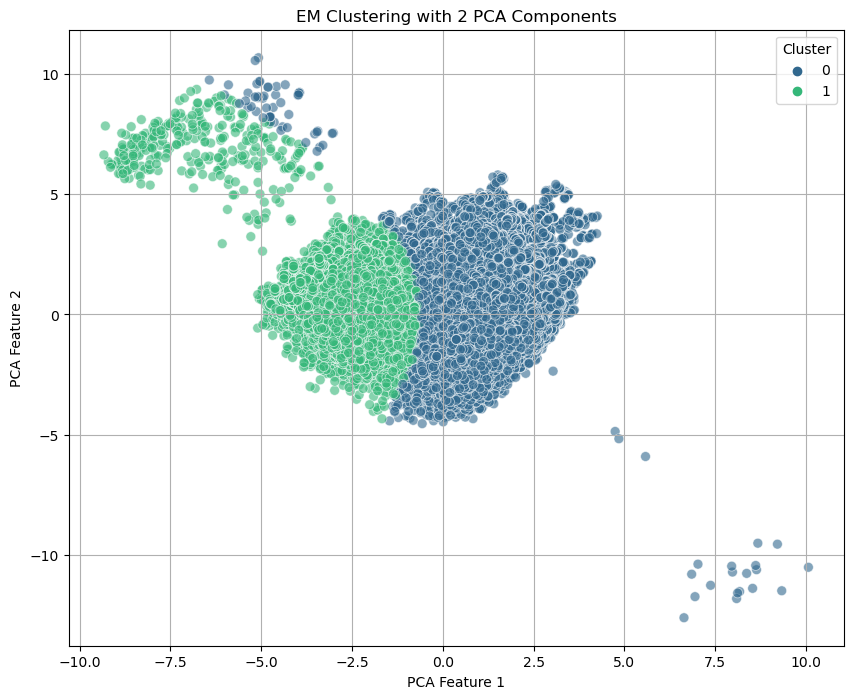

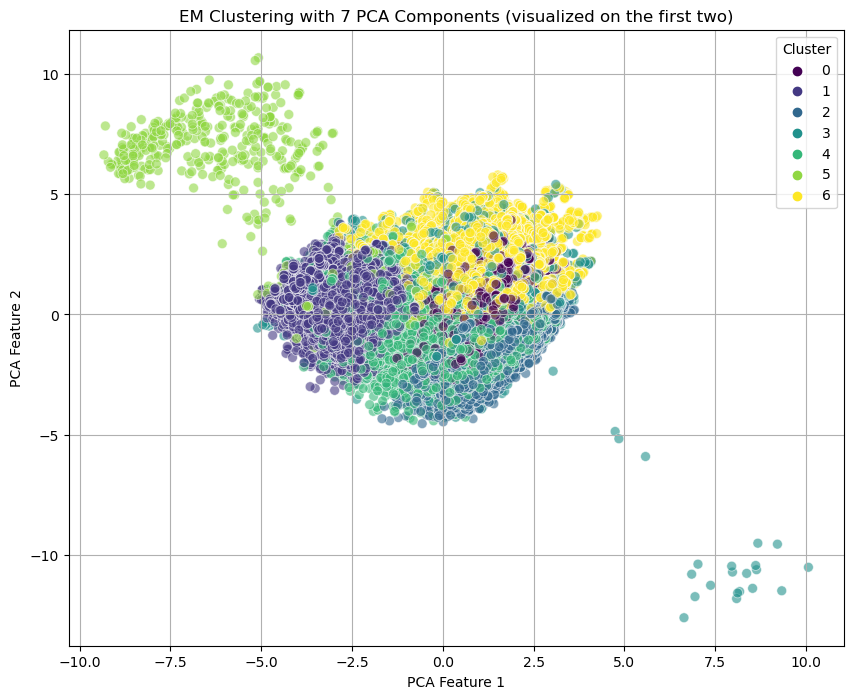

In [71]:
### code by GPT #### 
# Prepare and fit PCA
df_pca_2 = PCA(n_components=2).fit_transform(df_prepared)
df_pca_7 = PCA(n_components=7).fit_transform(df_prepared)

# Fit GMM for both PCA component settings
gmm_2 = GaussianMixture(n_components=2, random_state=42)
clusters_2 = gmm_2.fit_predict(df_pca_2)

gmm_7 = GaussianMixture(n_components=7, random_state=42)
clusters_7 = gmm_7.fit_predict(df_pca_7)

# Plotting for 2 components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca_2[:, 0], y=df_pca_2[:, 1], hue=clusters_2, palette='viridis', s=50, alpha=0.6)
plt.title('EM Clustering with 2 PCA Components')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Plotting for 7 components, projecting back to the first two principal components for visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca_7[:, 0], y=df_pca_7[:, 1], hue=clusters_7, palette='viridis', s=50, alpha=0.6)
plt.title('EM Clustering with 7 PCA Components (visualized on the first two)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
